In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time, datetime, argparse
import os, sys
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
import copy as cp
import pickle

PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)

import casadi as cas
import src.MPC_Casadi as mpc
import src.TrafficWorld as tw
import src.IterativeBestResponseMPCMultiple as mibr
import src.car_plotting_multiple as cmplot

In [3]:
svo_theta = np.pi/4.0
# random_seed = args.random_seed[0]
random_seed = 3
NEW = True
if NEW:
    optional_suffix = "multiple"
    subdir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + optional_suffix
    folder = "results/" + subdir_name + "/"
    os.makedirs(folder)
    os.makedirs(folder+"imgs/")
    os.makedirs(folder+"data/")
    os.makedirs(folder+"vids/")
    os.makedirs(folder+"plots/")
else:
    subdir_name = "20200224-103456_real_dim_CA"
    folder = "results/" + subdir_name + "/"
print(folder)
if random_seed > 0:
    np.random.seed(random_seed)

results/20200327_165903multiple/


In [4]:
T = 3  # MPC Planning Horizon
dt = 0.3
N = int(T/dt) #Number of control intervals in MPC
n_rounds_mpc = 6
percent_mpc_executed = 0.5 ## This is the percent of MPC that is executed
number_ctrl_pts_executed =  int(np.floor(N*percent_mpc_executed))
XAMB_ONLY = False

n_other = 2
n_rounds_ibr = 2

world = tw.TrafficWorld(2, 0, 1000)
    # large_world = tw.TrafficWorld(2, 0, 1000, 5.0)

#########################################################################
actual_xamb = np.zeros((6, n_rounds_mpc*number_ctrl_pts_executed + 1))
actual_uamb = np.zeros((2, n_rounds_mpc*number_ctrl_pts_executed))
actual_xothers = [np.zeros((6, n_rounds_mpc*number_ctrl_pts_executed + 1)) for i in range(n_other)]
actual_uothers = [np.zeros((2, n_rounds_mpc*number_ctrl_pts_executed)) for i in range(n_other)]
actual_all_other_x0 = [np.zeros((6, 2*N)) for i in range(n_other)]


xamb = np.zeros(shape=(6, N+1))
t_start_time = time.time()
####################################################
## Create the Cars in this Problem
all_other_x0 = []
all_other_u = []
all_other_MPC = []
all_other_x = [np.zeros(shape=(6, N+1)) for i in range(n_other)]
next_x0 = 0
for i in range(n_other):
    x1_MPC = mpc.MPC(dt)
    x1_MPC.n_circles = 3
    x1_MPC.theta_iamb =  svo_theta
    x1_MPC.N = N
    x1_MPC.k_change_u_v = 0.001
    x1_MPC.max_delta_u = 50 * np.pi/180 * x1_MPC.dt
    x1_MPC.k_u_v = 0.01
    x1_MPC.k_u_delta = .00001
    x1_MPC.k_change_u_v = 0.01
    x1_MPC.k_change_u_delta = 0.001

    x1_MPC.k_s = 0
    x1_MPC.k_x = 0
    x1_MPC.k_x_dot = -1.0 / 100.0
    x1_MPC.k_lat = 0.001
    x1_MPC.k_lon = 0.0

    x1_MPC.k_phi_error = 0.001
    x1_MPC.k_phi_dot = 0.01    
    
    ####Vehicle Initial Conditions
    if i%2 == 0: 
        lane_number = 0
        next_x0 += x1_MPC.L + 2*x1_MPC.min_dist
    else:
        lane_number = 1
    initial_speed = 0.75*x1_MPC.max_v
    traffic_world = world
    x1_MPC.fd = x1_MPC.gen_f_desired_lane(traffic_world, lane_number, True)
    x0 = np.array([next_x0, traffic_world.get_lane_centerline_y(lane_number), 0, 0, initial_speed, 0]).T

    ## Set the initial control of the other vehicles
    u1 = np.zeros((2,N))
    # u1[0,:] = np.clip(np.pi/180 *np.random.normal(size=(1,N)), -2 * np.pi/180, 2 * np.pi/180)
    SAME_SIDE = False
    if lane_number == 1 or SAME_SIDE:
        u1[0,0] = 2 * np.pi/180
    else:
        u1[0,0] = -2 * np.pi/180
    u1[0,0] = 0 

    all_other_MPC += [x1_MPC]
    all_other_x0 += [x0]
    all_other_u += [u1]    

# Settings for Ambulance
amb_MPC = cp.deepcopy(x1_MPC)
amb_MPC.theta_iamb = 0.0

amb_MPC.k_u_v = 0.0000
amb_MPC.k_u_delta = .01
amb_MPC.k_change_u_v = 0.0000
amb_MPC.k_change_u_delta = 0

amb_MPC.k_s = 0
amb_MPC.k_x = 0
amb_MPC.k_x_dot = -1.0 / 100.0

amb_MPC.k_x = -1.0/100
amb_MPC.k_x_dot = 0

amb_MPC.k_lat = 0.00001
amb_MPC.k_lon = 0.0
# amb_MPC.min_v = 0.8*initial_speed
amb_MPC.max_v = 35 * 0.447 # m/s
amb_MPC.k_phi_error = 0.1
amb_MPC.k_phi_dot = 0.01

NO_GRASS = False
amb_MPC.min_y = world.y_min        
amb_MPC.max_y = world.y_max
if NO_GRASS:
    amb_MPC.min_y += world.grass_width
    amb_MPC.max_y -= world.grass_width
amb_MPC.fd = amb_MPC.gen_f_desired_lane(world, 0, True)
x0_amb = np.array([0, 0, 0, 0, initial_speed , 0]).T
pickle.dump(x1_MPC, open(folder + "data/"+"mpc%d"%i + ".p",'wb'))
pickle.dump(amb_MPC, open(folder + "data/"+"mpcamb" + ".p",'wb'))

In [9]:
for i_mpc in range(n_rounds_mpc):
    min_slack = np.infty
    actual_t = i_mpc * number_ctrl_pts_executed
    ###### Update the initial conditions for all vehicles
    if i_mpc > 0:
        x0_amb = xamb[:, number_ctrl_pts_executed] 
        for i in range(len(all_other_x0)):
            all_other_x0[i] = all_other_x[i][:, number_ctrl_pts_executed]        

        

    ###### Initial guess for the other u.  This will be updated once the other vehicles
    ###### solve the best response to the ambulance. Initial guess just looks at the last solution. This could also be a lange change
    # Obtain a simulated trajectory from other vehicle control inputs
    all_other_x = [np.zeros(shape=(6, N+1)) for i in range(n_other)]
    all_other_x_des = [np.zeros(shape=(3, N+1)) for i in range(n_other)]
    for i in range(n_other):
        if i_mpc == 0:
            all_other_u[i] = np.zeros(shape=(2,N))
        else:
            all_other_u[i] = np.concatenate((all_other_u[i][:, number_ctrl_pts_executed:], np.tile(all_other_u[i][:,-1:],(1, number_ctrl_pts_executed))),axis=1) ##   
        x_mpci, u_all_i, x_0_i = all_other_MPC[i], all_other_u[i], all_other_x0[i]
        print(x_mpci, u_all_i, x_0_i)
        all_other_x[i], all_other_x_des[i] = x_mpci.forward_simulate_all(x_0_i, u_all_i)

    for i_rounds_ibr in range(n_rounds_ibr):  
        ########## Solve the Ambulance MPC ##########
        response_MPC = amb_MPC
        response_x0 = x0_amb
        
        nonresponse_MPC_list = all_other_MPC
        nonresponse_x0_list = all_other_x0
        nonresponse_u_list = all_other_u
        nonresponse_x_list = all_other_x
        nonresponse_xd_list = all_other_x_des
        ################# Generate the warm starts ###############################

        u_warm_profiles = mibr.generate_warm_u(N, response_MPC)
        ### Ambulance Warm Start
        if i_rounds_ibr > 0:   # warm start with the solution from the last IBR round
            u_warm_profiles["previous"] = uamb    
        else:
            # take the control inputs of the last MPC and continue the ctrl
            if i_mpc > 0:
                u_warm_profiles["previous"] = np.concatenate((uamb[:, number_ctrl_pts_executed:], np.tile(uamb[:,-1:],(1, number_ctrl_pts_executed))),axis=1) ##    
        #######################################################################
        min_response_cost = 99999999
        for k_warm in u_warm_profiles.keys():
            u_warm = u_warm_profiles[k_warm]
            x_warm, x_des_warm = response_MPC.forward_simulate_all(response_x0.reshape(6,1), u_warm)
            bri = mibr.IterativeBestResponseMPCMultiple(response_MPC, None, nonresponse_MPC_list )
            k_slack = 10000.0
            k_CA = 0.000000000000000
            k_CA_power = 4
            wall_CA = True

            bri.k_slack = k_slack
            bri.k_CA = k_CA
            bri.k_CA_power = k_CA_power
            bri.world = world
            bri.wall_CA = wall_CA
            
            # for slack_var in bri.slack_vars_list: ## Added to constrain slacks
            #     bri.opti.subject_to(cas.vec(slack_var) <= 1.0)
            INFEASIBLE = True            
            bri.generate_optimization(N, T, response_x0, None, nonresponse_x0_list,  1, slack=False)
            bri.opti.set_initial(bri.u_opt, u_warm)            
            bri.opti.set_initial(bri.x_opt, x_warm)
            bri.opti.set_initial(bri.x_desired, x_des_warm)   
        
            ### Set the trajectories of the nonresponse vehicles (as given)        
            for i in range(n_other):
                bri.opti.set_value(bri.allother_x_opt[i], nonresponse_x_list[i])
                bri.opti.set_value(bri.allother_x_desired[i], nonresponse_xd_list[i])
            
            ### Solve the Optimization
            # Debugging
            # plot_range = [N]
            # bri.opti.callback(lambda i: bri.debug_callback(i, plot_range))
            # bri.opti.callback(lambda i: print("J_i %.03f,  J_j %.03f, Slack %.03f, CA  %.03f"%(bri.solution.value(bri.response_svo_cost), bri.solution.value(bri.other_svo_cost), bri.solution.value(bri.k_slack*bri.slack_cost), bri.solution.value(bri.k_CA*bri.collision_cost))))
            try:
                bri.solve(None, nonresponse_u_list)
                x1, u1, x1_des, _, _, _, _, _, _ = bri.get_solution()

                print("i_mpc %d n_round %d i %02d Cost %.02f Slack %.02f "%(i_mpc, i_rounds_ibr, i, bri.solution.value(bri.total_svo_cost), bri.solution.value(bri.slack_cost)))
                print("J_i %.03f,  J_j %.03f, Slack %.03f, CA  %.03f"%(bri.solution.value(bri.response_svo_cost), bri.solution.value(bri.other_svo_cost), bri.solution.value(bri.k_slack*bri.slack_cost), bri.solution.value(bri.k_CA*bri.collision_cost)))
                print("Dir:", subdir_name)
                print("k_warm", k_warm)
                INFEASIBLE = False
                if bri.solution.value(bri.slack_cost) < min_slack:
                    current_cost = bri.solution.value(bri.total_svo_cost)
                    if current_cost < min_response_cost:
                        uamb = u1
                        xamb = x1
                        xamb_des = x1_des
                        min_response_cost = current_cost
                        min_response_warm = k_warm
                        min_bri = bri
                        # file_name = folder + "data/"+'%03d'%ibr_sub_it
                        # mibr.save_state(file_name, xamb, uamb, xamb_des, all_other_x, all_other_u, all_other_x_des)
                        # mibr.save_costs(file_name, bri)                  
            except RuntimeError:
                print("Infeasibility: k_warm %s"%k_warm)
                # ibr_sub_it +=1

        ########### SOLVE FOR THE OTHER VEHICLES ON THE ROAD
        if not XAMB_ONLY:
            for i in range(len(all_other_MPC)):
                response_MPC = all_other_MPC[i]
                response_x0 = all_other_x0[i]

                nonresponse_MPC_list = all_other_MPC[:i] + all_other_MPC[i+1:]
                nonresponse_x0_list = all_other_x0[:i] + all_other_x0[i+1:]
                nonresponse_u_list = all_other_u[:i] + all_other_u[i+1:]
                nonresponse_x_list = all_other_x[:i] + all_other_x[i+1:]
                nonresponse_xd_list = all_other_x_des[:i] + all_other_x_des[i+1:]
                ################  Warm Start
                u_warm_profiles = mibr.generate_warm_u(N, response_MPC)
                if i_rounds_ibr > 0:   # warm start with the solution from the last IBR round
                    u_warm_profiles["previous"] = all_other_u[i] 
                else:
                    # take the control inputs of the last MPC and continue the ctrl
                    if i_mpc > 0:
                        u_warm_profiles["previous"] = np.concatenate((all_other_u[i][:, number_ctrl_pts_executed:], np.tile(all_other_u[i][:,-1:],(1, number_ctrl_pts_executed))),axis=1) ##    

                min_response_cost = 99999999
                for k_warm in u_warm_profiles.keys():
                    u_warm = u_warm_profiles[k_warm]
                    x_warm, x_des_warm = response_MPC.forward_simulate_all(response_x0.reshape(6,1), u_warm)
                    
                    bri = mibr.IterativeBestResponseMPCMultiple(response_MPC, amb_MPC, nonresponse_MPC_list)
                    bri.k_slack = k_slack
                    bri.k_CA = k_CA
                    bri.k_CA_power = k_CA_power
                    bri.world = world
                    bri.wall_CA = wall_CA

                    INFEASIBLE = True            
                    bri.generate_optimization(N, T, response_x0, x0_amb, nonresponse_x0_list,  1, slack=False)
                    # for slack_var in bri.slack_vars_list: ## Added to constrain slacks
                    #     bri.opti.subject_to(cas.vec(slack_var) <= 1.0)                    
                    bri.opti.set_initial(bri.u_opt, u_warm)            
                    bri.opti.set_initial(bri.x_opt, x_warm)
                    bri.opti.set_initial(bri.x_desired, x_des_warm)   

                    ### Set the trajectories of the nonresponse vehicles (as given)        
                    bri.opti.set_value(bri.xamb_opt, xamb)
                    for j in range(len(nonresponse_x_list)):
                        bri.opti.set_value(bri.allother_x_opt[j], nonresponse_x_list[j])
                        bri.opti.set_value(bri.allother_x_desired[j], nonresponse_xd_list[j])
                    
                    # Debugging
                    # bri.opti.callback(lambda i: bri.debug_callback(i, [N]))
                    # bri.opti.callback(lambda i: print("J_i %.03f,  J_j %.03f, Slack %.03f, CA  %.03f"%(bri.solution.value(bri.response_svo_cost), bri.solution.value(bri.other_svo_cost), bri.solution.value(bri.k_slack*bri.slack_cost), bri.solution.value(bri.k_CA*bri.collision_cost))))
                    try:                     ### Solve the Optimization
                        bri.solve(uamb, nonresponse_u_list)
                        x1_nr, u1_nr, x1_des_nr, _, _, _, _, _, _ = bri.get_solution()

                        print("  i_mpc %d n_round %d i %02d Cost %.02f Slack %.02f "%(i_mpc, i_rounds_ibr, i, bri.solution.value(bri.total_svo_cost), bri.solution.value(bri.slack_cost)))
                        print("  J_i %.03f,  J_j %.03f, Slack %.03f, CA  %.03f"%(bri.solution.value(bri.response_svo_cost), bri.solution.value(bri.other_svo_cost), bri.solution.value(bri.k_slack*bri.slack_cost), bri.solution.value(bri.k_CA*bri.collision_cost)))
                        print("  Dir:", subdir_name)
                        print("  k_warm", k_warm)
                        INFEASIBLE = False
                        if bri.solution.value(bri.slack_cost) < min_slack:
                            current_cost = bri.solution.value(bri.total_svo_cost)
                            if current_cost < min_response_cost:
                                all_other_u[i] = u1_nr
                                all_other_x = all_other_x[:i] + [x1_nr] + all_other_x[i:]
                                all_other_u = all_other_u[:i] + [u1_nr] + all_other_u[i:]
                                all_other_x_des = all_other_x_des[:i] + [x1_des_nr] + all_other_x_des[i:]

                                min_response_cost = current_cost
                                min_response_warm = k_warm
                                min_bri = bri
                                # file_name = folder + "data/"+'%03d'%ibr_sub_it
                                # mibr.save_state(file_name, xamb, uamb, xamb_des, all_other_x, all_other_u, all_other_x_des)
                                # mibr.save_costs(file_name, bri)
                    except RuntimeError:
                        print("  Infeasibility: k_warm %s"%k_warm)
                        # ibr_sub_it +=1     
                        # 
        print("  IBR Done:  Rd %02d / %02d"%(i_rounds_ibr, n_rounds_ibr))

    file_name = folder + "data/"+'r%02d%03d'%(i_mpc, i_rounds_ibr)
    if not INFEASIBLE:
        mibr.save_state(file_name, xamb, uamb, xamb_des, xothers, uothers, xothers_des)
        mibr.save_costs(file_name, bri)
        actual_t = i_mpc * number_ctrl_pts_executed
        actual_xamb[:,actual_t:actual_t+number_ctrl_pts_executed+1]  = xamb[:,:number_ctrl_pts_executed+1]
        print(" MPC Done:  Rd %02d / %02d"%(i_mpc, n_rounds_mpc))
        print(" Full MPC Solution", xamb[0:2,:])
        print(" Executed MPC", xamb[0:2,:number_ctrl_pts_executed+1])
        print(" Solution Costs...")
        for cost in bri.car1_costs_list:
            print("%.04f"%bri.solution.value(cost))
        print(min_bri.solution.value(min_bri.k_CA * min_bri.collision_cost), min_bri.solution.value(min_bri.collision_cost))
        print(min_bri.solution.value(min_bri.k_slack * min_bri.slack_cost), min_bri.solution.value(min_bri.slack_cost))
        print(" Save to...", file_name)
        actual_uamb[:,actual_t:actual_t+number_ctrl_pts_executed] = uamb[:,:number_ctrl_pts_executed]
        plot_range = range(N+1)
        for k in plot_range:
            cmplot.plot_multiple_cars( k, min_bri.responseMPC, xothers, xamb, True, None, None, None, min_bri.world, 0)     
            plt.show()
        plt.plot(xamb[4,:],'--')
        plt.plot(xamb[4,:] * np.cos(xamb[2,:]))
        plt.ylabel("Velocity / Vx")
        plt.hlines(35*0.447,0,xamb.shape[1])
        plt.show()
        plt.plot(uamb[1,:],'o')
        plt.hlines(amb_MPC.max_v_u,0,xamb.shape[1])
        plt.ylabel("delta_u_v")
        plt.show()
        for i in range(len(xothers)):
            actual_xothers[i][:,actual_t:actual_t+number_ctrl_pts_executed+1] = xothers[i][:,:number_ctrl_pts_executed+1]
            actual_uothers[i][:,actual_t:actual_t+number_ctrl_pts_executed] = uothers[i][:,:number_ctrl_pts_executed]
#             all_other_u[i] = np.concatenate((uothers[i][:, number_ctrl_pts_executed:],uothers[i][:,:number_ctrl_pts_executed]),axis=1)
    else:
        raise Exception("Xamb is None", i_mpc, i_rounds_ibr, "slack cost", bri.solution.value(bri.slack_cost))

print("Solver Done!  Runtime: %.1d"%(time.time()-t_start_time))


<src.MPC_Casadi.MPC object at 0x7f2a76eea550> [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9.59 0.   0.   0.   8.38 0.  ]
<src.MPC_Casadi.MPC object at 0x7f2ad9688610> [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9.59 3.7  0.   0.   8.38 0.  ]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 296.00us ( 16.44us) 294.86us ( 16.38us)        18
       nlp_g  |   1.89ms (104.78us)   1.89ms (105.12us)        18
    nlp_grad  | 429.00us (429.00us) 430.51us (430.51us)         1
  nlp_grad_f  | 397.00us ( 20.89us) 398.29us ( 20.96us)        19
  nlp_hess_l  |  14.00ms (823.82us)  14.04ms (825.63us)        17
   nlp_jac_g  |   8.46ms (445.26us)   8.49ms (446.85us)        19
       total  |  39.27ms ( 39.27ms)  39.27ms ( 39.27ms)         1
i_mpc 0 n_round 0 i 01 Cost -5.04 Slack 0.00 
J_i -5.042,  J_j 0.000, Slack 0.000, CA  0.000
Dir: 20200327_165903multiple
k_warm lane_change_left braking
      solver  :   t_proc    

AttributeError: 'IterativeBestResponseMPCMultiple' object has no attribute 'solution'

In [923]:
import time 
t_start_time = datetime.time()

In [926]:
t_start_time

datetime.time(0, 0)

In [799]:
x_mpc, xothers_plot, xamb_plot, CIRCLES, xothers_desired, xamb_desired, folder, world, camera_speed = bri.responseMPC, actual_xothers, actual_xamb, True, None, None, None, bri.world, 0

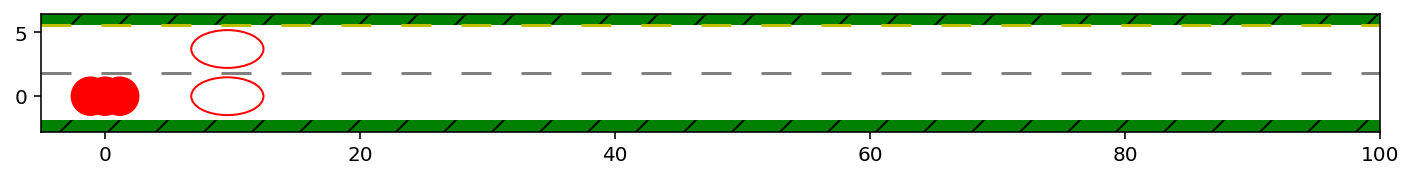

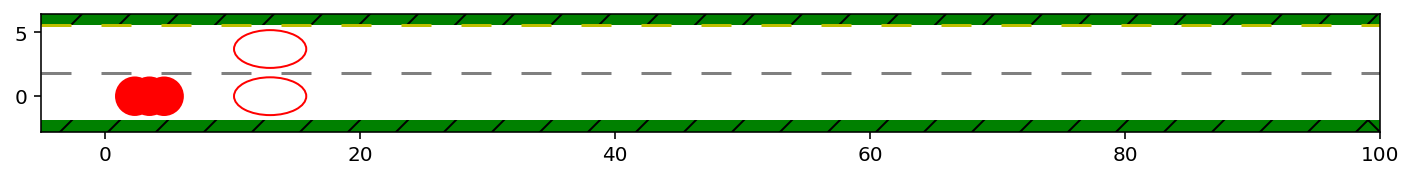

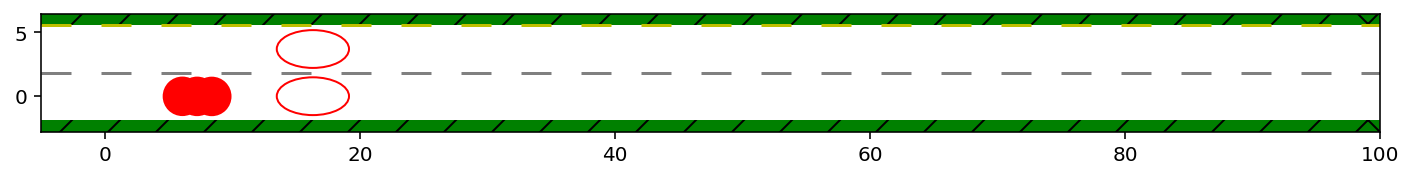

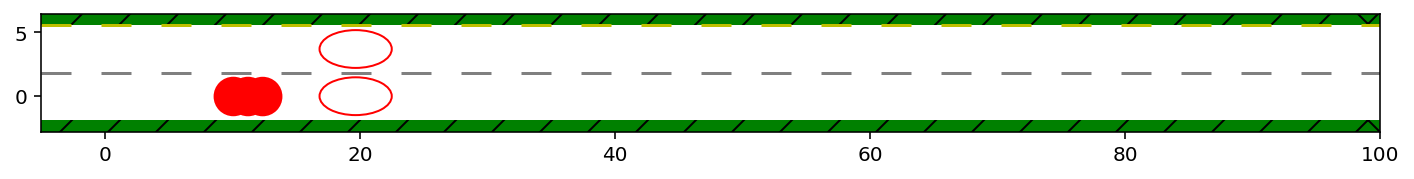

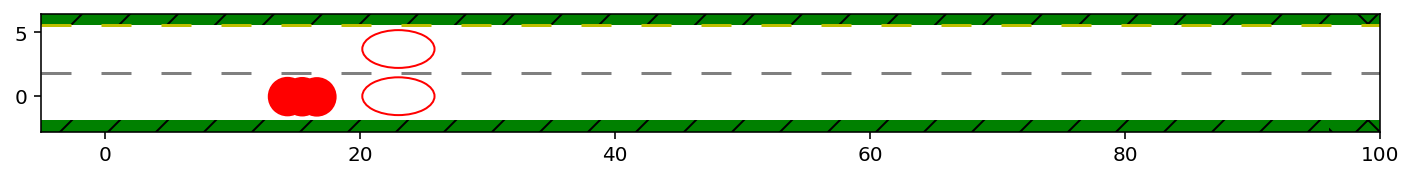

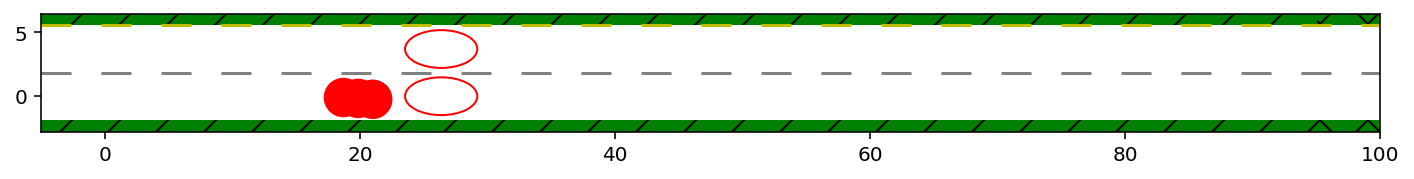

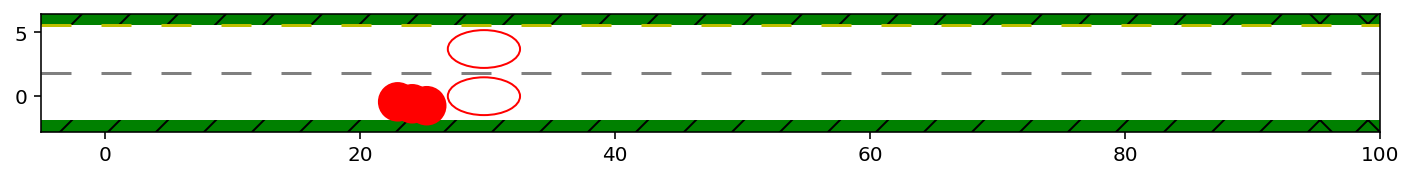

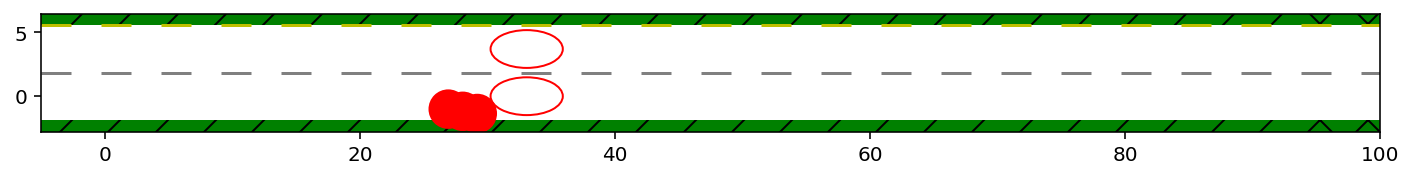

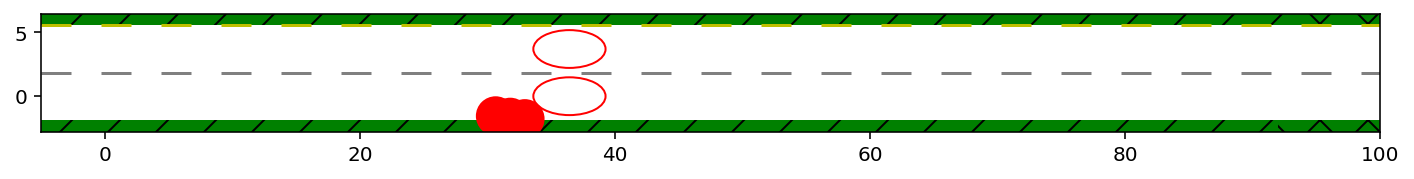

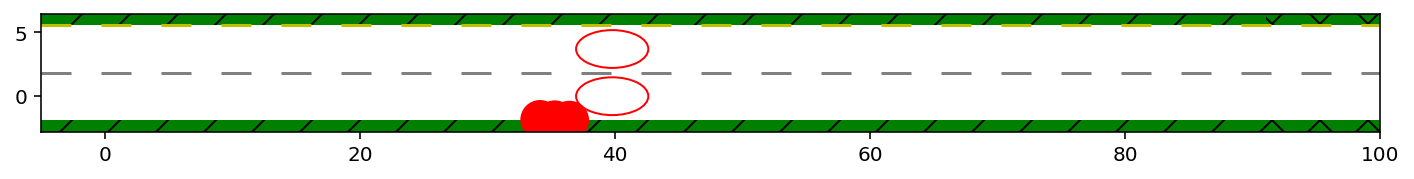

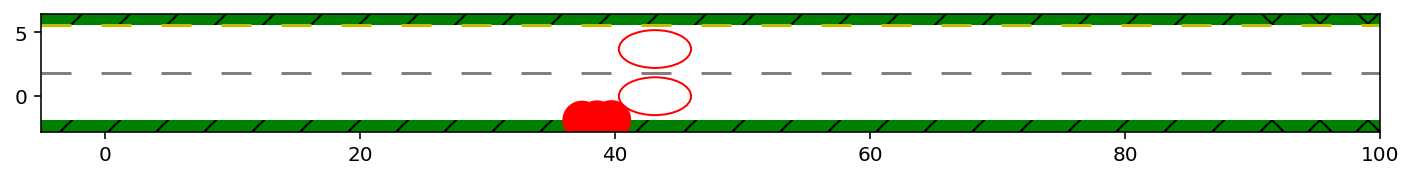

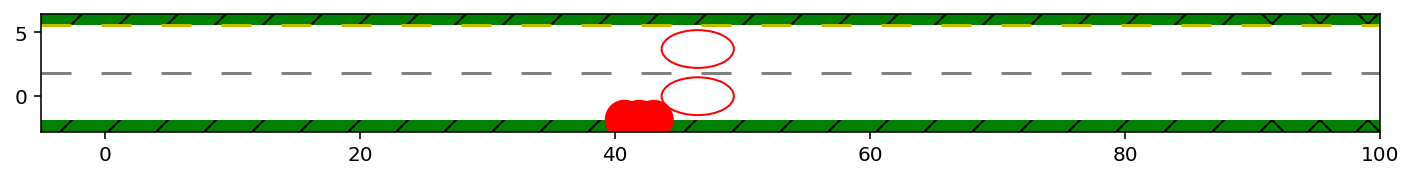

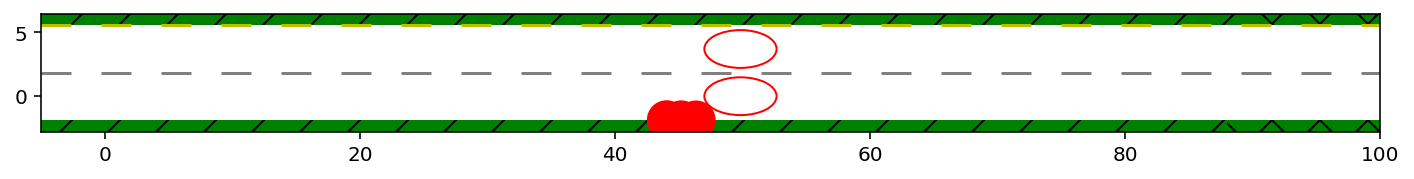

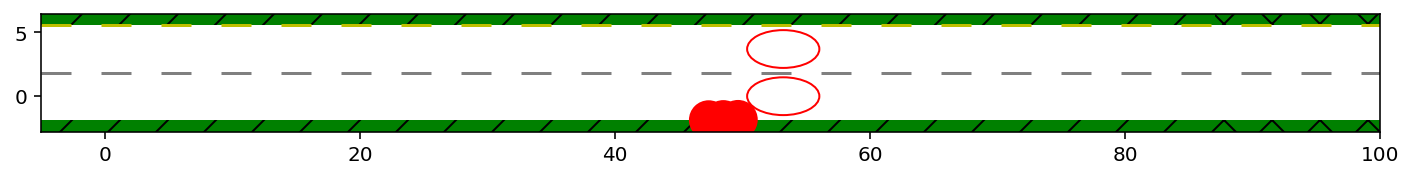

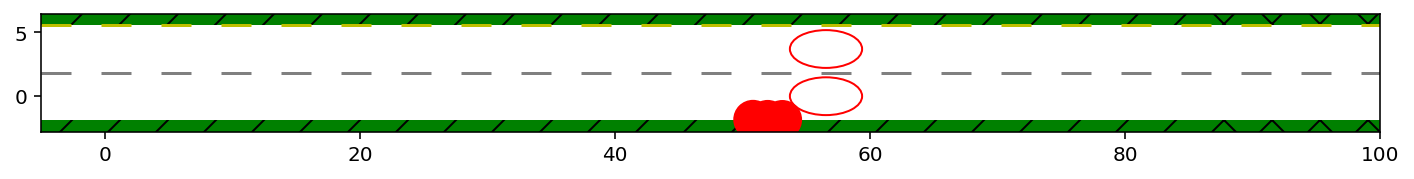

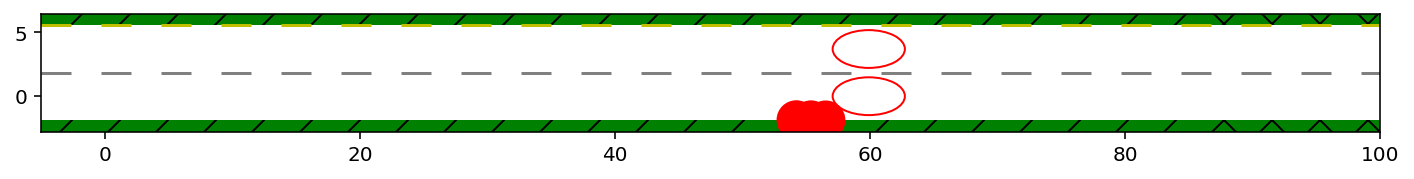

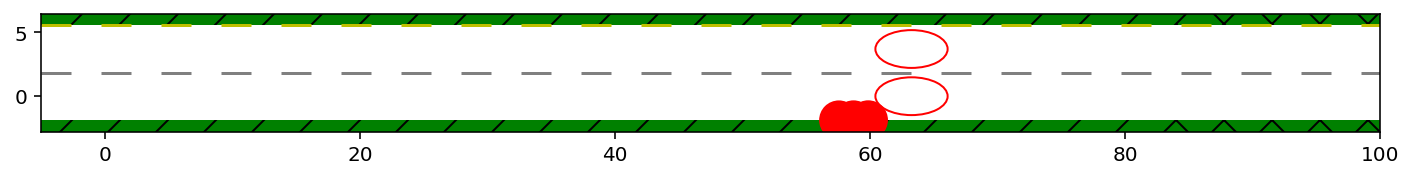

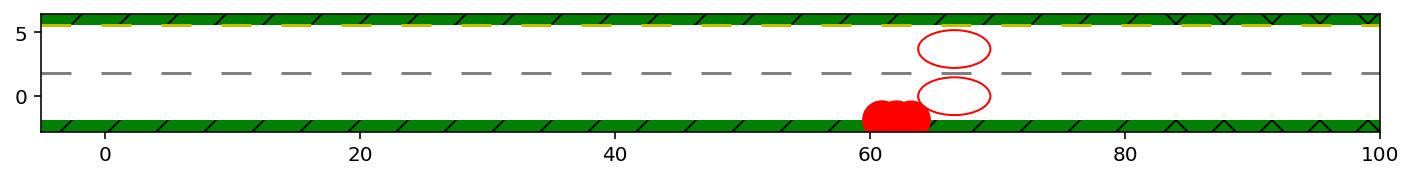

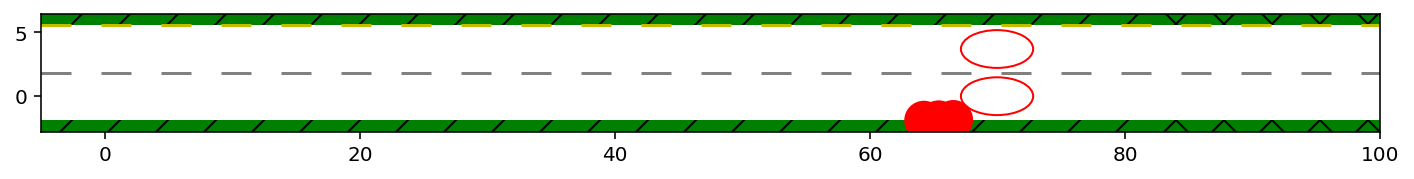

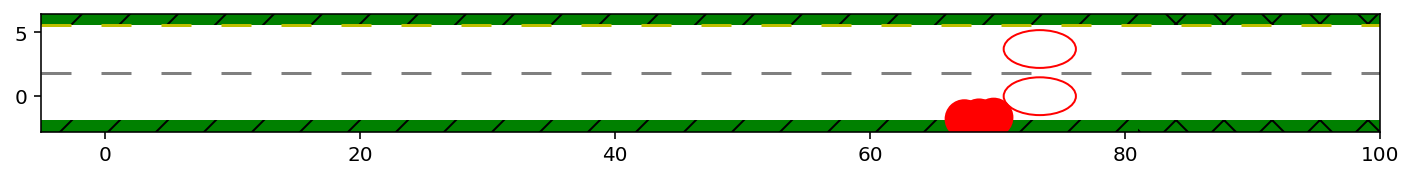

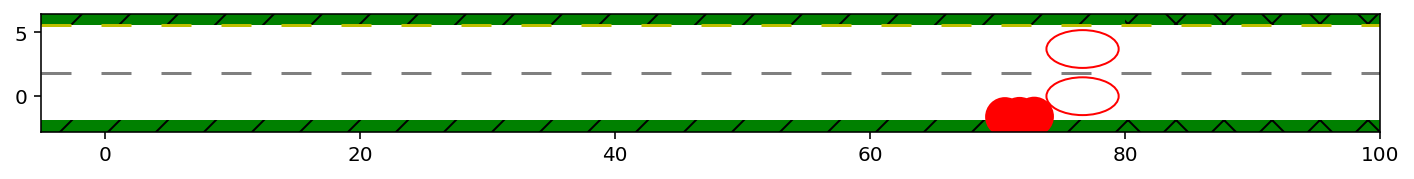

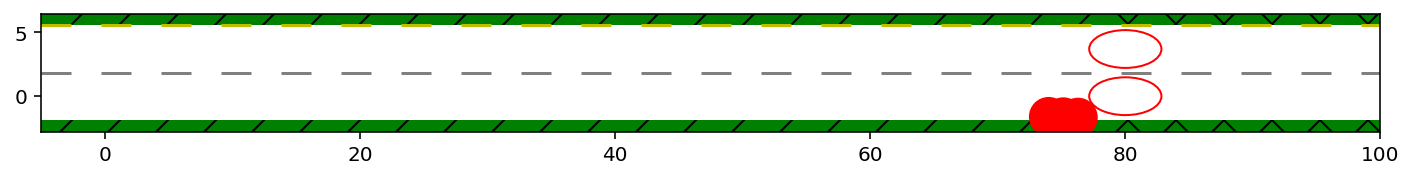

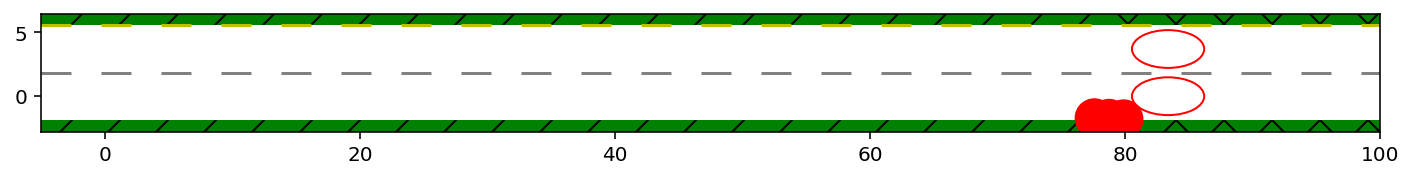

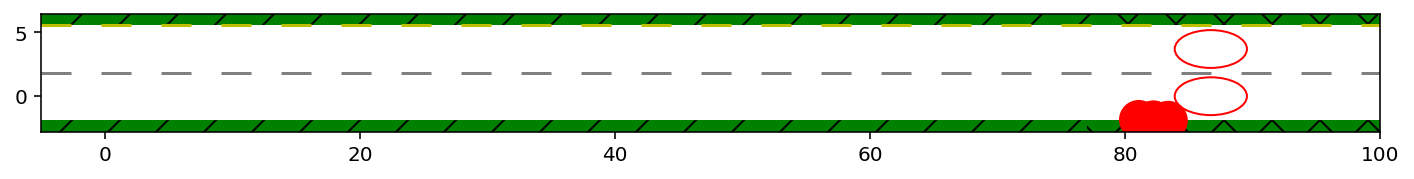

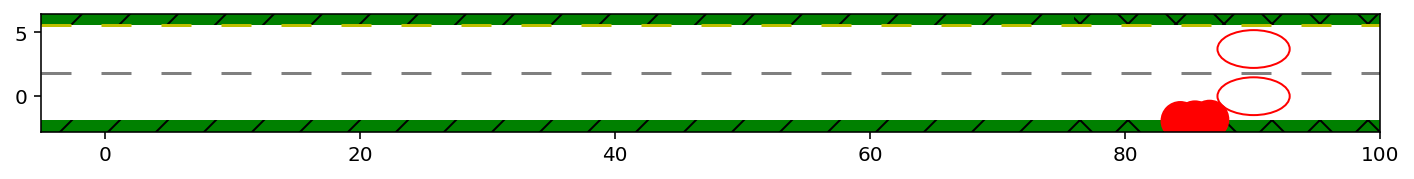

In [829]:
for k in range(actual_xamb.shape[1]):
    cmplot.plot_multiple_cars( k, bri.responseMPC, actual_xothers, actual_xamb, True, None, None, None, bri.world, 0)     
    plt.show()

In [795]:
[actual_xothers[i][0:2,:] for i in range(2)]

[array([[ 9.59, 12.94, 16.3 , 19.65, 23.  , 26.35, 29.71, 33.06, 36.41,
         39.76, 43.12, 46.47, 49.82, 53.17, 56.53, 59.88, 63.23, 66.58,
         69.94, 73.29, 76.64, 79.99, 83.35, 86.7 , 90.05],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]]),
 array([[ 9.59, 12.94, 16.3 , 19.65, 23.  , 26.35, 29.71, 33.06, 36.41,
         39.76, 43.12, 46.47, 49.82, 53.17, 56.53, 59.88, 63.23, 66.58,
         69.94, 73.29, 76.64, 79.99, 83.35, 86.7 , 90.05],
        [ 3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,
          3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,
          3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ,  3.7 ]])]

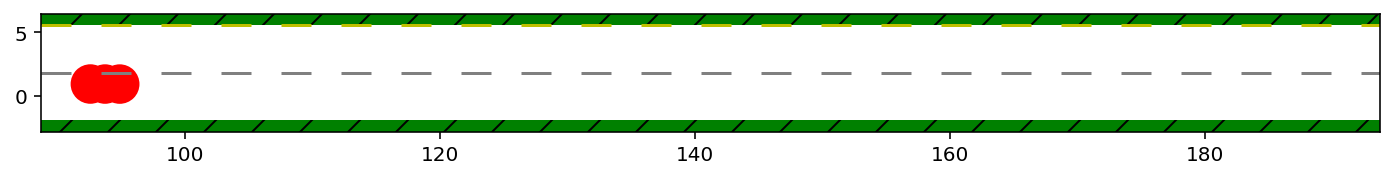

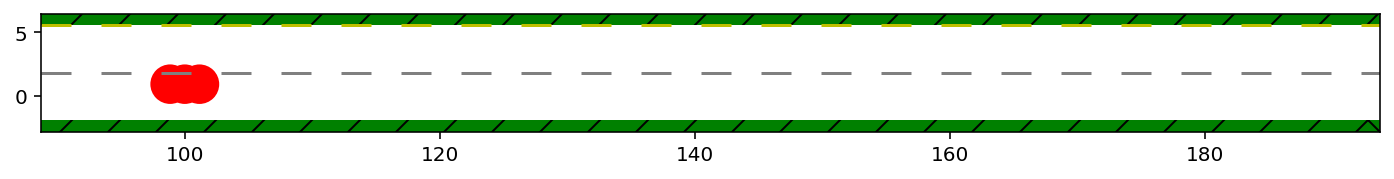

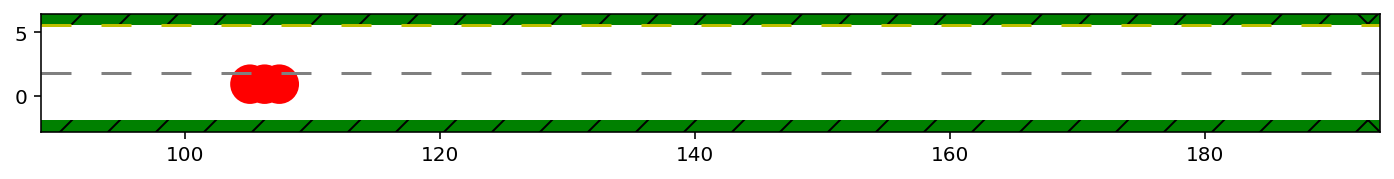

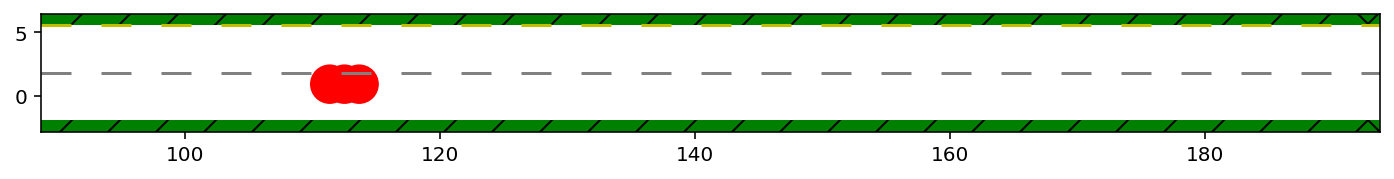

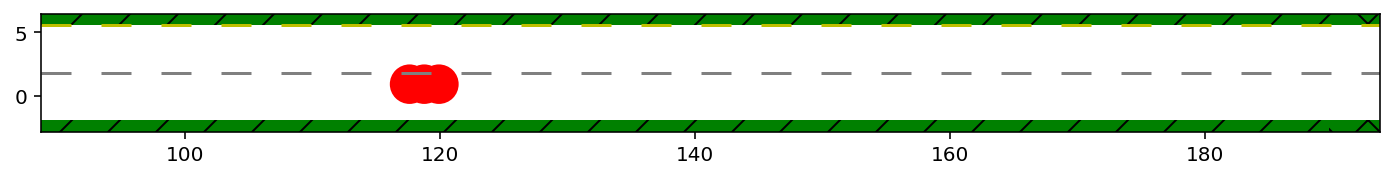

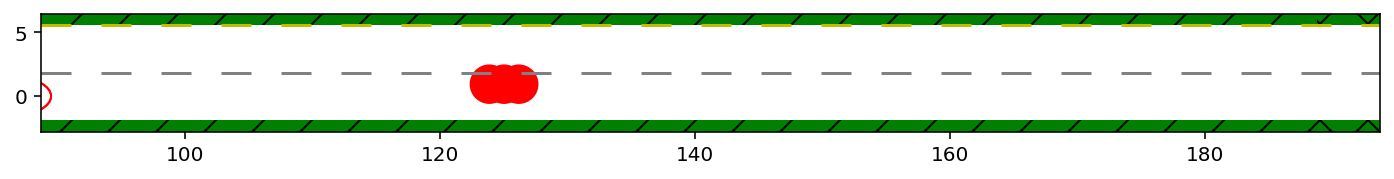

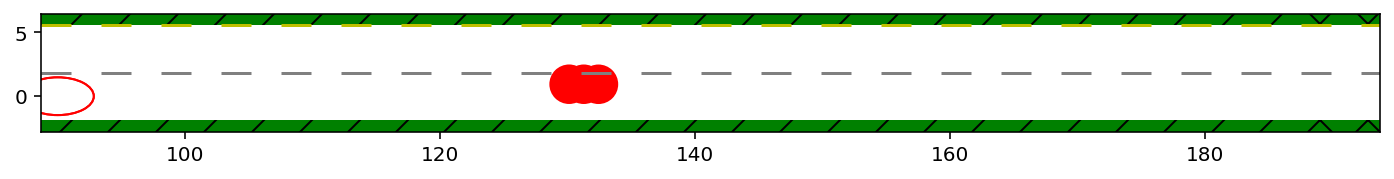

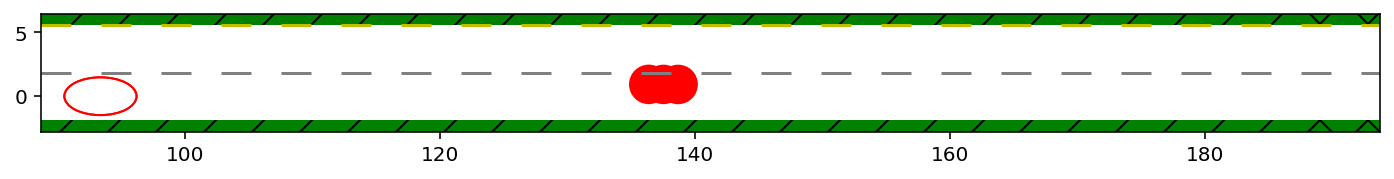

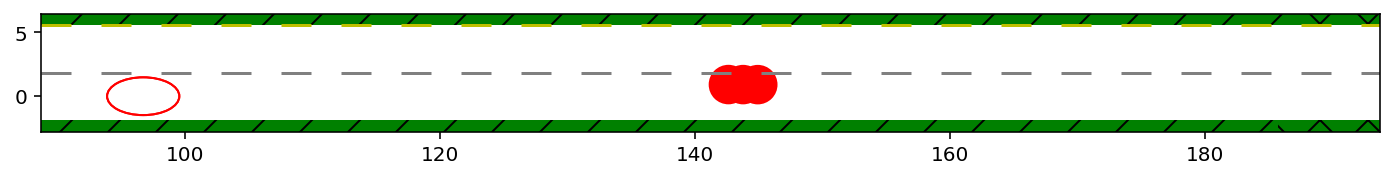

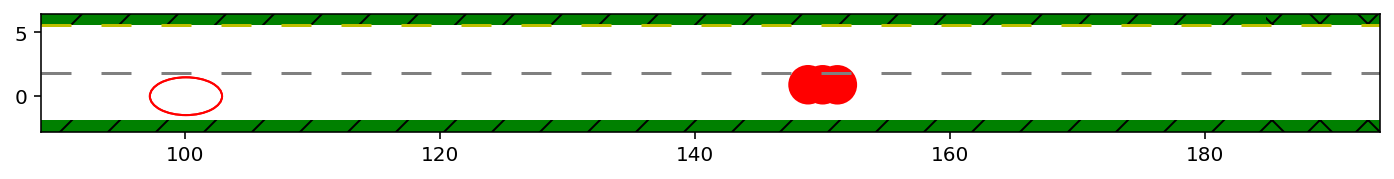

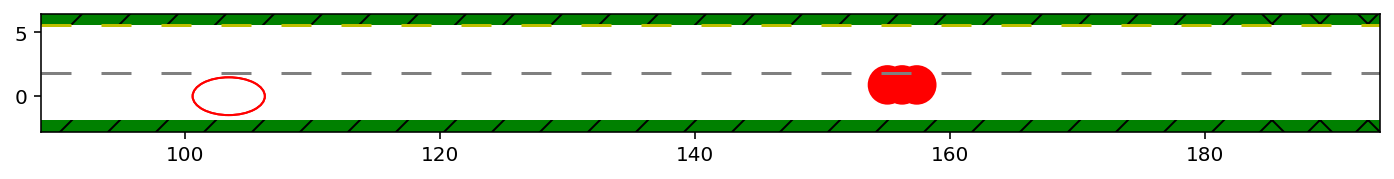

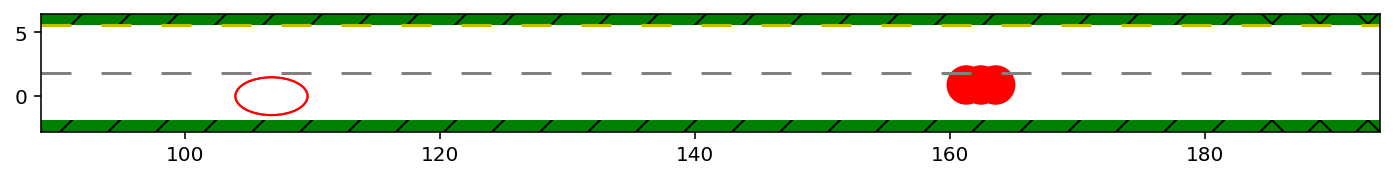

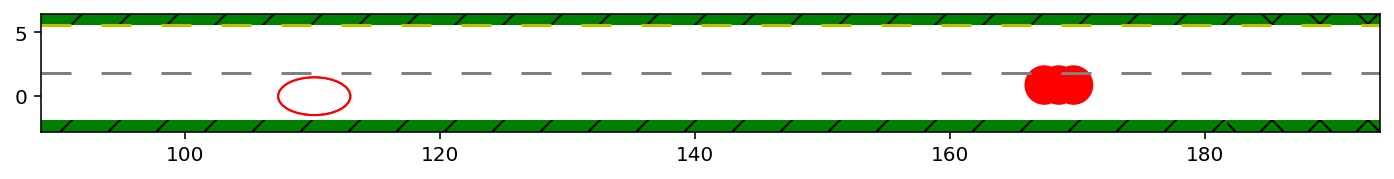

In [794]:
plot_range = range(N+1)
actual_xamb
for k in plot_range:
    cmplot.plot_multiple_cars( k, bri.responseMPC, xothers, xamb, True, None, None, None, bri.world, 0)     
    plt.show()

In [627]:
for i in range(len(bri.car1_costs_list)):
    print(" %.04f : %s"%(bri.opti.debug.value(bri.car1_costs_list[i]),bri.car1_cost_titles[i]))

 0.0047 : self.k_u_delta * self.u_delta_cost
 0.0000 : self.k_u_v * self.u_v_cost
 0.0007 : self.k_lat * self.lat_cost
 0.0000 : self.k_lon * self.lon_cost
 0.0119 : self.k_phi_error * self.phi_error_cost
 0.0040 : self.k_phi_dot * self.phidot_cost
 0.0000 : self.k_s * self.s_cost
 0.0000 : self.k_v * self.v_cost
 0.0000 : self.k_change_u_v * self.change_u_v
 0.0000 : self.k_change_u_delta * self.change_u_delta
 0.0000 : self.k_final * self.final_costs
 -9.9959 : self.k_x * self.x_cost
 0.0000 : self.k_x_dot * self.x_dot_cost


In [628]:
bri.opti.debug.value(bri.slack_cost)

2.813317717242071

In [652]:
slack_vars = bri.opti.debug.value(bri.slack_vars_list[0])
for k in range(slack_vars.shape[1]):
    print("%d %0.05f %.05f %.05f"%(k, slack_vars[0,k], slack_vars[1,k], slack_vars[2,k]))

0 0.00048 0.00048 0.00048
1 0.00048 0.00048 0.00048
2 0.00048 0.00048 0.00048
3 0.00048 0.00048 0.00048
4 0.00048 0.00048 0.00048
5 0.00048 0.00048 0.00048
6 0.10982 0.00048 0.00048
7 0.68566 0.00048 0.00048
8 0.98586 0.00048 0.00048
9 0.98627 0.00048 0.00048
10 0.83015 0.00048 0.00048
11 0.00048 0.00048 0.00048
12 0.00048 0.00048 0.00048


In [630]:
bri.opti.debug.value(bri.x_opt[0:2,:])

array([[ 0.00e+00,  3.48e+00,  7.22e+00,  1.12e+01,  1.54e+01,  1.97e+01,
         2.45e+01,  2.95e+01,  3.47e+01,  4.03e+01,  4.61e+01,  5.21e+01,
         5.82e+01],
       [ 0.00e+00, -2.66e-03,  2.23e-02,  3.22e-01,  1.16e+00,  2.18e+00,
         2.83e+00,  2.93e+00,  2.93e+00,  2.93e+00,  2.93e+00,  2.93e+00,
         2.92e+00]])

In [668]:
x0 = response_x0

In [673]:
x0_other = nonresponse_x0_list

In [674]:
x0_other

[array([9.59, 0.  , 0.  , 0.  , 8.38, 0.  ])]

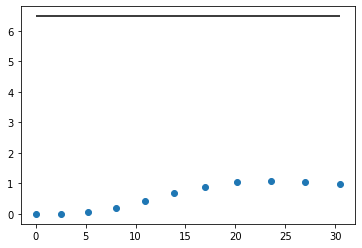

In [916]:
## OLD
ibr_sub_it = 1

# Ambulance initial control input guess
uamb_warm_initial = np.zeros((2,N))
uamb_warm_initial[0,0] = 0.5 * amb_MPC.max_delta_u
# uamb_warm_initial[0,1:] = 0
uamb_warm_initial[0,4] = -1*amb_MPC.max_delta_u
uamb_warm_initial[0,8] = 0.5 * amb_MPC.max_delta_u
# uamb_warm_initial[0,9:] = 0
# uamb_warm_initial[0,:] = 0
uamb_warm_initial[1,:] = np.ones(shape=(1,N)) * amb_MPC.max_v_u
xamb_warm, xamb_des_warm = amb_MPC.forward_simulate_all(x0_amb.reshape(6,1), uamb_warm_initial)
plt.hlines(amb_MPC.max_y, 0 , xamb_warm[0,-1])
plt.plot(xamb_warm[0,:], xamb_warm[1,:], 'o')
plt.show()

In [680]:
k = 7
centers, response_radius = bri.responseMPC.get_car_circles(bri.x_opt[:,k]) 
centers = [bri.opti.debug.value(c) for c in centers]
i = 0


alphas = []
betas = []

for i in range(len(bri.otherMPClist)):
    a_other, b_other, delta, a, b = bri.otherMPClist[i].get_collision_ellipse(response_radius)
    alphas += [a_other]
    betas += [b_other]

print(alphas, betas)

[array([4.35])] [array([3.])]


In [689]:
test_value = bri.solution.value(bri.x_opt[0:2,k])
print(test_value)

[29.47  2.93]


In [685]:
initial_displacement = x0_other[i] - x0
initial_xy_distance = np.sqrt(initial_displacement[0]**2 + initial_displacement[1]**2)
for c1_circle in centers:
    print("circle", c1_circle)
    ci = 0
    buffer_distance = bri.generate_collision_ellipse(c1_circle[0], c1_circle[1], 
                                    bri.allother_x_opt[i][0,k], bri.allother_x_opt[i][1,k], bri.allother_x_opt[i][2,k],
                                    alphas[i], betas[i], bri.slack_vars_list[i][ci,k])
    # distance_clipped = cas.fmax(buffer_distance, -1)
    distance_clipped = cas.fmax(buffer_distance, 0.01)
    bri.collision_cost += 1/distance_clipped**bri.k_CA_power   

circle [28.32  2.93]
circle [29.47  2.93]
circle [30.62  2.93]


L, W 4.5 1.8
a, b [4.35] [3.]

[[1, 0], 
 [-0, 1]] 
[[0.0529391, 0], 
 [0, 0.111391]] [-2.43677, 2.92702]
30.621895655655628 2.927019582450009 1.26869 Outside?: 1


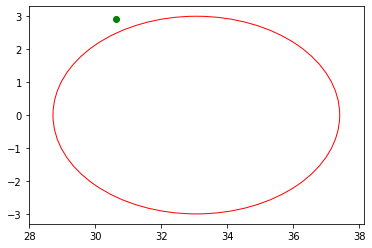

In [742]:
x_o, y_o = bri.solution.value(bri.allother_x_opt[i][0,k]), bri.solution.value(bri.allother_x_opt[i][1,k])
test_y = [c1_circle[1]]
text_x = [c1_circle[0]]

alpha_o, beta_o, = alphas[i], betas[i]
print("L, W", amb_MPC.L, amb_MPC.W)
print("a, b", alpha_o, beta_o)
import matplotlib.patches as patches
phi_o = bri.solution.value(bri.allother_x_opt[i][2,k])
plt.figure()
ellipse_patch = patches.Ellipse((x_o, y_o), 2*alpha_o, 2*beta_o, angle=np.rad2deg(phi_o), fill=False, edgecolor='red')
ax = plt.gca()
ax.add_patch(ellipse_patch)
ax.axis('equal')
for x_e in text_x:
    for y_e in test_y:
        slack = None
        
        dx = x_e - x_o
        dy = y_e - y_o
        if slack is None:
            slack = 0
        R_o = cas.vertcat(cas.horzcat(cas.cos(phi_o), cas.sin(phi_o)), cas.horzcat(-cas.sin(phi_o), cas.cos(phi_o)))
        M = cas.vertcat(cas.horzcat(1/alpha_o**2, 0), cas.horzcat(0, 1/beta_o**2))
        dX = cas.vertcat(dx, dy)
        prod =    cas.mtimes([dX.T, R_o.T, M, R_o, dX])        
        if prod>=1:
            color = 'g'
        else:
            color = 'r'
        plt.plot(x_e, y_e,'o', c=color)
        print(R_o, M, dX)
        print(x_e, y_e, prod, "Outside?:", prod>=1)


In [738]:
import sympy as sym

sdx = sym.Symbol('dx')
sdy = sym.Symbol('dy')
stheta = sym.Symbol('theta')
sa = sym.Symbol('alpha')
sb = sym.Symbol('beta')

R_o = sym.Matrix([[sym.cos(stheta), sym.sin(stheta)], [-sym.sin(stheta), sym.cos(stheta)]])
# R_o = sym.Matrix([[sym.sin(stheta), -sym.cos(stheta)], [sym.cos(stheta), sym.sin(stheta)]])
print(R_o)
ss = sym.Symbol('sin')
sc = sym.Symbol('cos')
# R_o = sym.Matrix([[sc, -ss], [ss, sc]])

# R_o = sym.Matrix([[sym.cos(stheta), 0], [0, sym.sin(stheta)]])
M = sym.Matrix([[1/sa**2, 0],[0, 1/sb**2]])
dX = sym.Matrix([[sdx],[sdy]])

Matrix([[cos(theta), sin(theta)], [-sin(theta), cos(theta)]])


In [739]:
prod = dX.T @ R_o.T @ M @ R_o @ dX        
prod

Matrix([[dx*(-(-dx*sin(theta) + dy*cos(theta))*sin(theta)/beta**2 + (dx*cos(theta) + dy*sin(theta))*cos(theta)/alpha**2) + dy*((-dx*sin(theta) + dy*cos(theta))*cos(theta)/beta**2 + (dx*cos(theta) + dy*sin(theta))*sin(theta)/alpha**2)]])

In [723]:
sym.simplify(prod)

Matrix([[(dx*(alpha**2*sin*(cos*dy + dx*sin) + beta**2*cos*(cos*dx - dy*sin)) + dy*(alpha**2*cos*(cos*dy + dx*sin) - beta**2*sin*(cos*dx - dy*sin)))/(alpha**2*beta**2)]])

L, W 4.5 1.8
a, b [4.35] [3.]
80 1.5 11.9113 Outside?: 1
85 1.5 5.29391 Outside?: 1
90 1.5 1.32348 Outside?: 1
95 1.5 0 Outside?: 0
100 1.5 1.32348 Outside?: 1


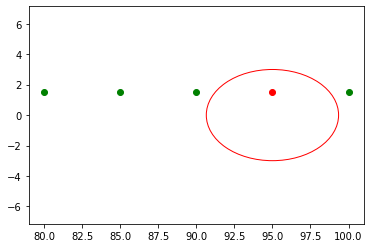

In [382]:
x_o, y_o = (95, 0)
test_y = [1.5]
text_x = [80, 85, 90, 95, 100]
r=1.47
alpha_o, beta_o, _, _, _, = amb_MPC.get_collision_ellipse(r)
print("L, W", amb_MPC.L, amb_MPC.W)
print("a, b", alpha_o, beta_o)
import matplotlib.patches as patches
phi_o = 0
plt.figure()
ellipse_patch = patches.Ellipse((x_o, y_o), 2*alpha_o, 2*beta_o, angle=np.rad2deg(phi_o), fill=False, edgecolor='red')
ax = plt.gca()
ax.add_patch(ellipse_patch)
ax.axis('equal')
for x_e in text_x:
    for y_e in test_y:
        slack = None
        
        dx = x_o - x_e
        dy = y_o - y_e
        if slack is None:
            slack = 0
        R_o = cas.vertcat(cas.horzcat(cas.cos(phi_o), 0), cas.horzcat(0, cas.sin(phi_o)))
        M = cas.vertcat(cas.horzcat(1/alpha_o**2, 0), cas.horzcat(0, 1/beta_o**2))
        dX = cas.vertcat(dx, dy)
        prod =    cas.mtimes([dX.T, R_o.T, M, R_o, dX])        
        
        if prod>=1:
            color = 'g'
        else:
            color = 'r'
        plt.plot(x_e, y_e,'o', c=color)
        
        print(x_e, y_e, prod, "Outside?:", prod>=1)


In [691]:
bri.solution.value(buffer_distance)

1.2573794838249228

In [643]:
k = 9
centers, response_radius = bri.responseMPC.get_car_circles(bri.x_opt[:,k]) 
centers = [bri.opti.debug.value(c) for c in centers]


In [644]:
centers

[array([39.12,  2.93]), array([40.27,  2.93]), array([41.42,  2.93])]

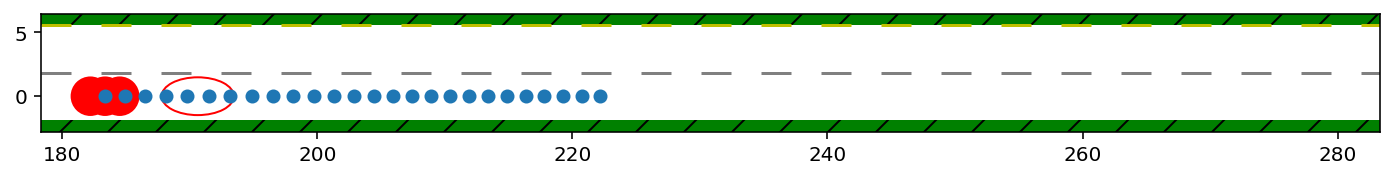

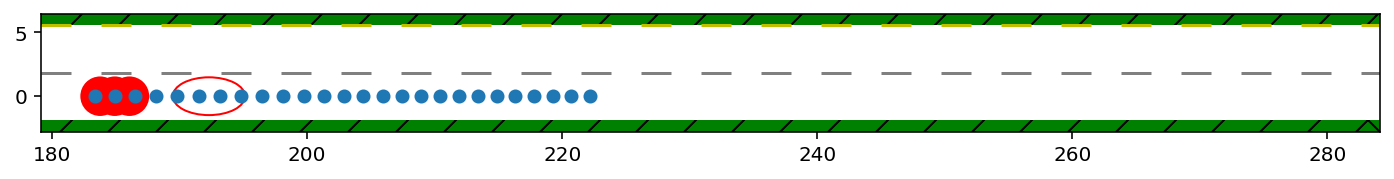

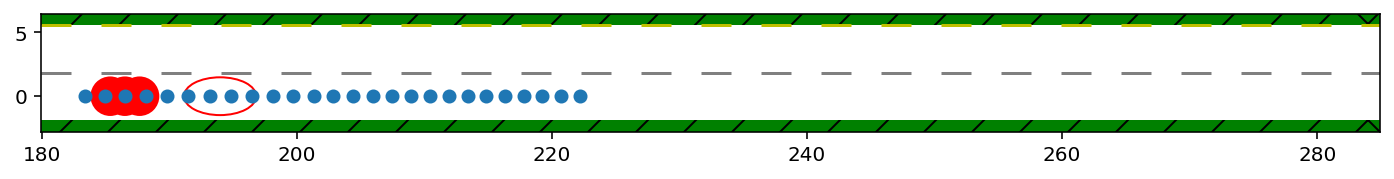

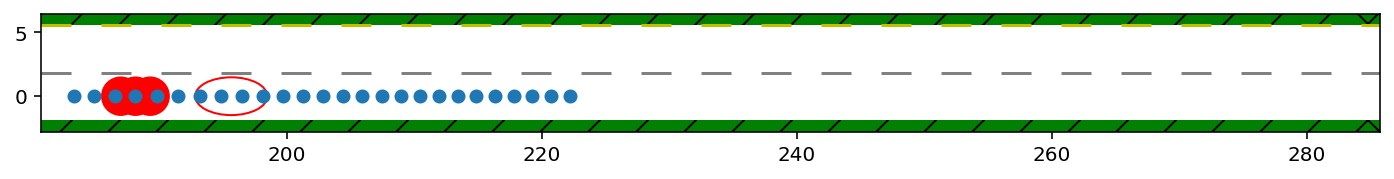

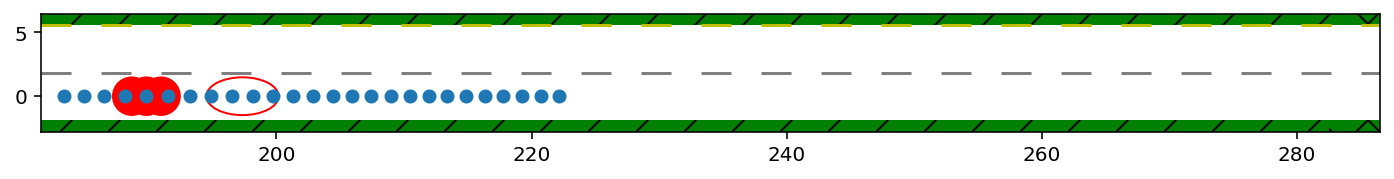

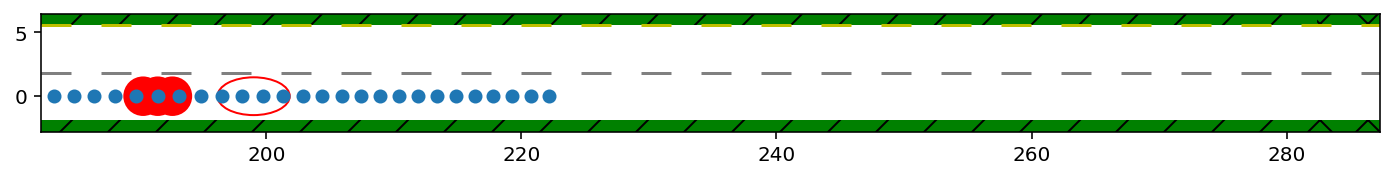

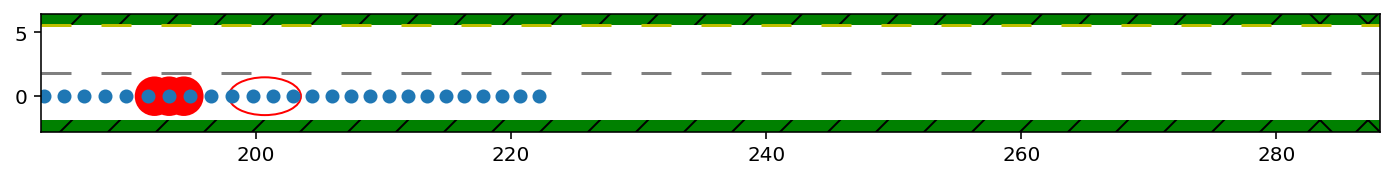

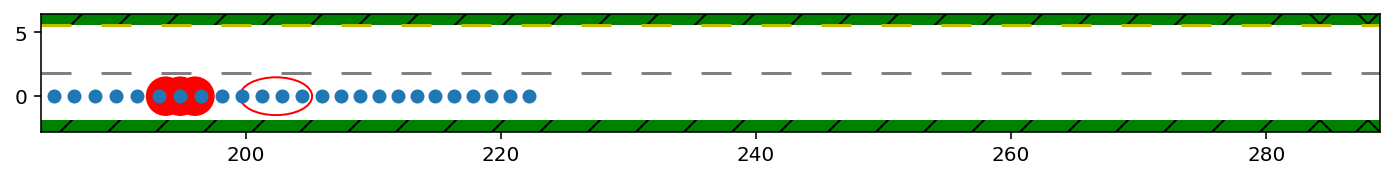

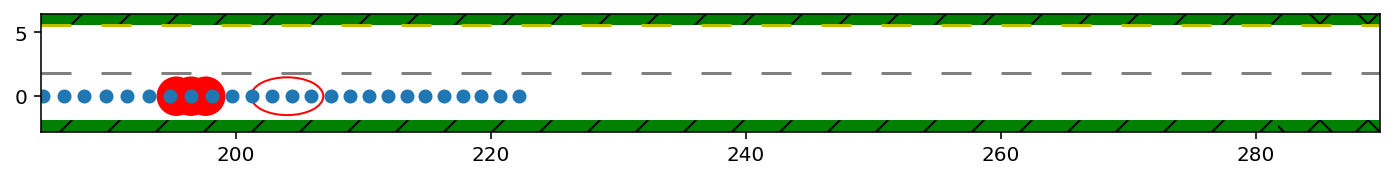

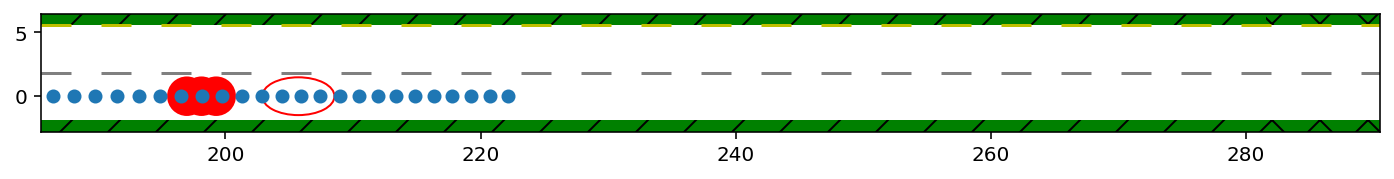

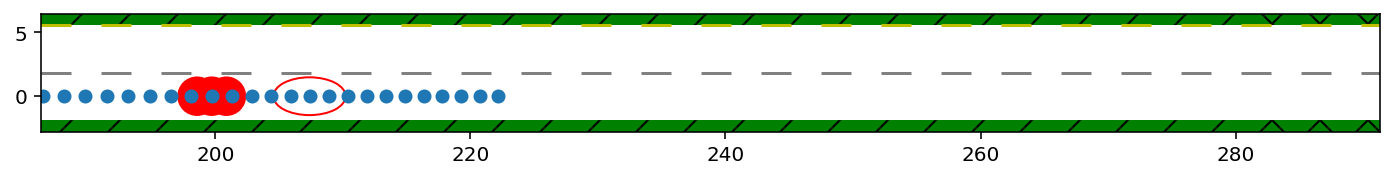

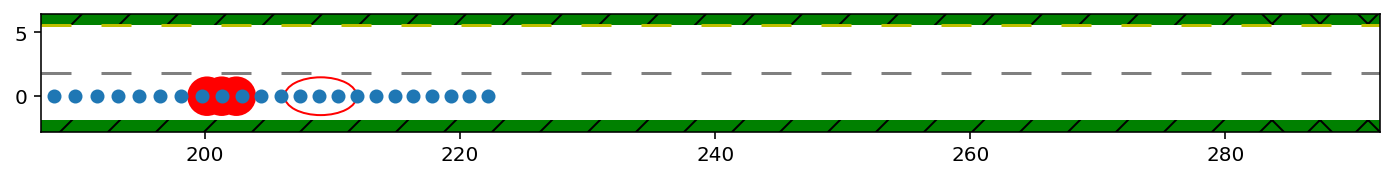

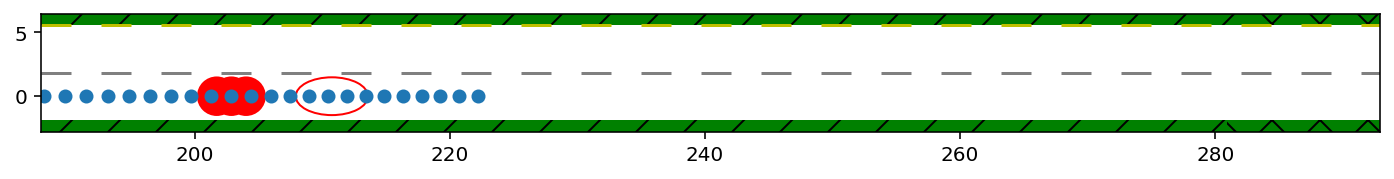

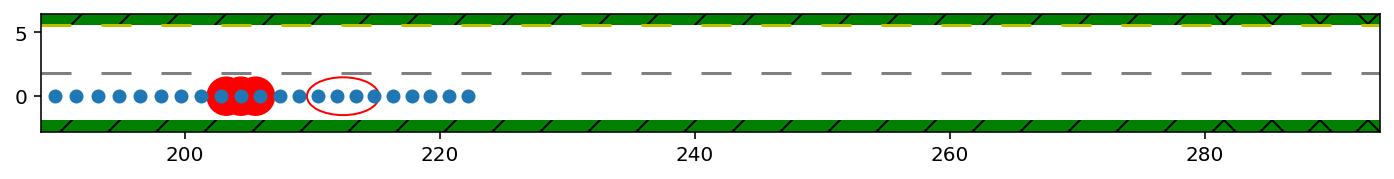

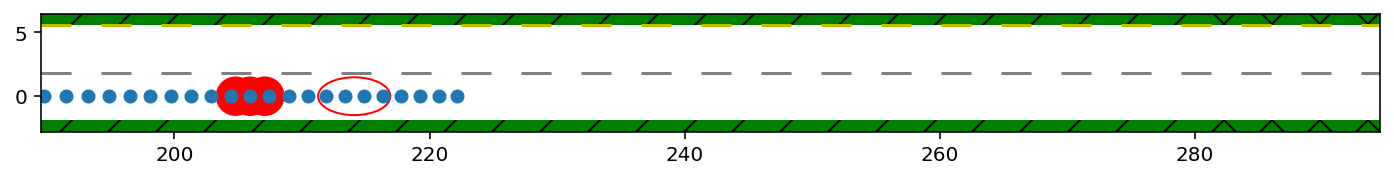

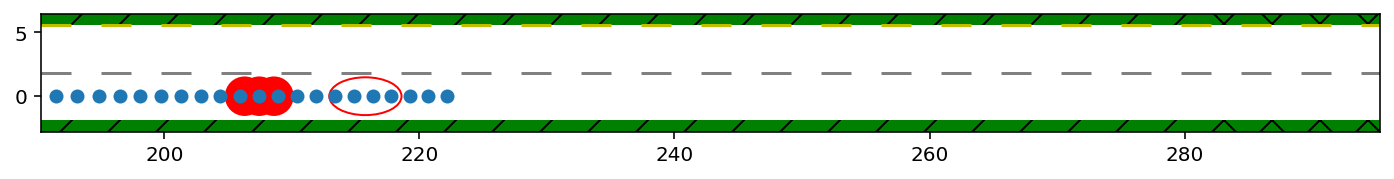

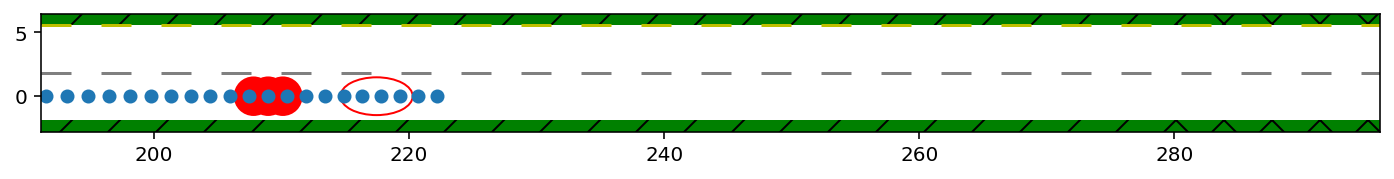

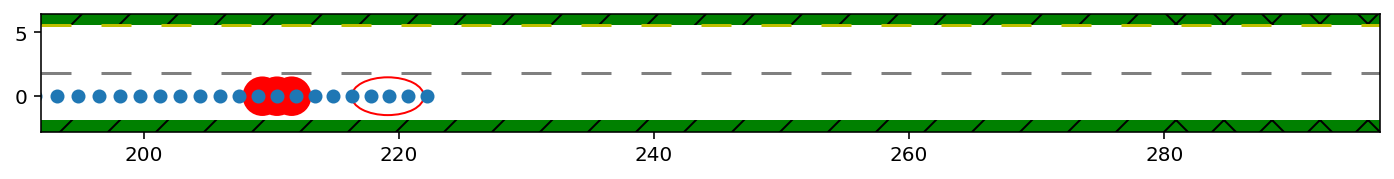

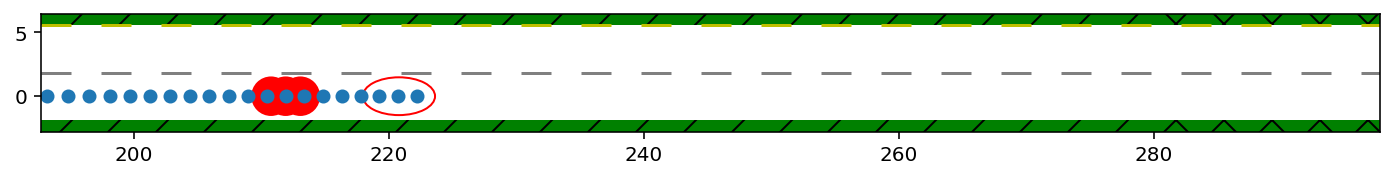

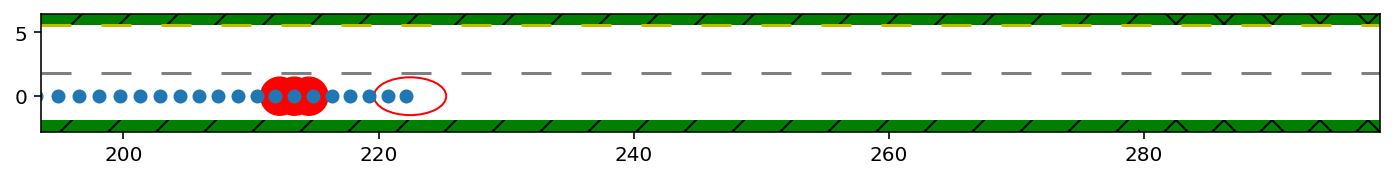

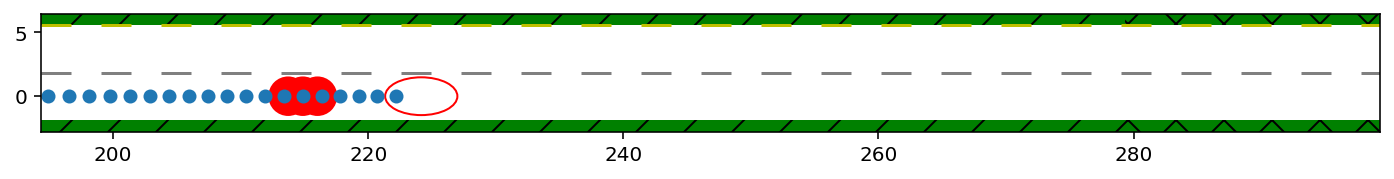

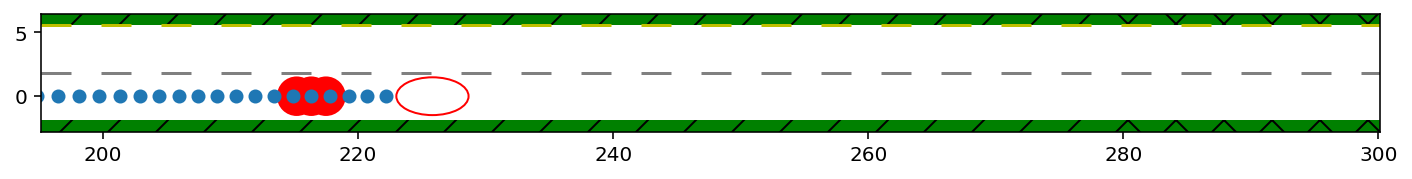

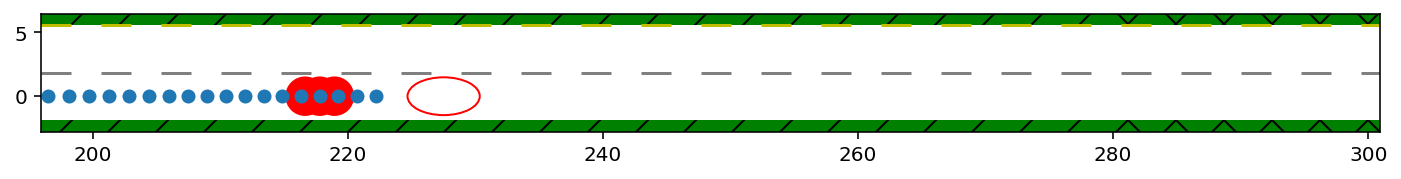

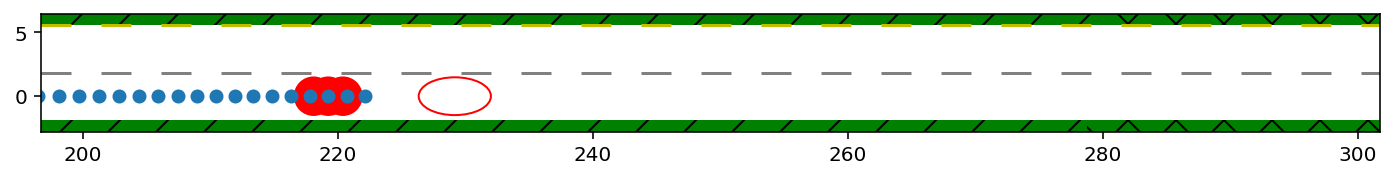

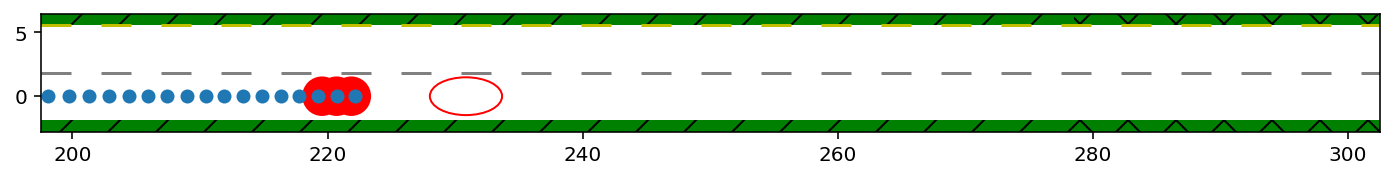

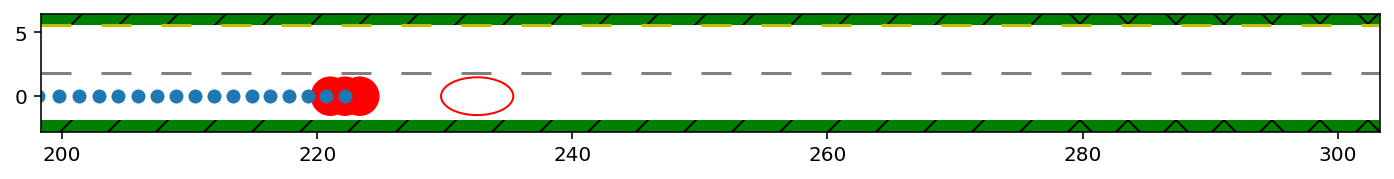

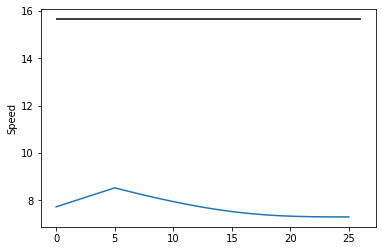

In [485]:
CIRCLES=True
xothers_plot = [bri.opti.debug.value(xo) for xo in bri.allother_x_opt]
xamb_plot = bri.opti.debug.value(bri.x_opt)
plot_range = range(xamb_plot.shape[1])
for k in plot_range:
    cmplot.plot_multiple_cars( k, bri.responseMPC, xothers_plot, xamb_plot, CIRCLES, None, None, None, bri.world, 4)     
    plt.plot(xamb_plot[0,:], xamb_plot[1,:],'o')
    plt.show()
plt.plot(xamb_plot[4,:])
plt.hlines(35*0.447,0,xamb_plot.shape[1])
plt.ylabel('Speed')
plt.show()

In [384]:
bri.solution.value(bri.x_opt[0:2,-5:])

array([[58.09, 65.01, 72.43, 80.18, 88.  ],
       [ 0.73,  0.78,  0.83,  0.87,  0.88]])

In [376]:
alpha

array([4.35])

In [25]:
# random_seed = args.random_seed[0]

svo_theta = np.pi/4.0

random_seed = 3
NEW = True
if NEW:
    optional_suffix = "ellipses"
    subdir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + optional_suffix
    folder = "results/" + subdir_name + "/"
    os.makedirs(folder)
    os.makedirs(folder+"imgs/")
    os.makedirs(folder+"data/")
    os.makedirs(folder+"vids/")
    os.makedirs(folder+"plots/")
else:
    subdir_name = "20200224-103456_real_dim_CA"
    folder = "results/" + subdir_name + "/"
print(folder)
if random_seed > 0:
    np.random.seed(random_seed)

results/20200316_131917ellipses/


In [79]:
T = 10
dt = 0.2
N = int(T/dt) #Number of control intervals
print(N)
world = tw.TrafficWorld(2, 0, 1000)
n_other = 1

all_other_x0 = []
all_other_u = []
all_other_MPC = []
next_x0 = 0
for i in range(n_other):
    x1_MPC = mpc.MPC(dt)
    x1_MPC.n_circles = 3
    x1_MPC.theta_iamb =  svo_theta
    x1_MPC.N = N
    
    
    

    x1_MPC.k_u_v = 0.01
    x1_MPC.k_u_delta = .00001
    x1_MPC.k_change_u_v = 0.01
    x1_MPC.k_change_u_delta = 0

    x1_MPC.k_s = 0
    x1_MPC.k_x = 0
    x1_MPC.k_x_dot = -1.0 / 100.0
    x1_MPC.k_lat = 0.001
    x1_MPC.k_lon = 0.0
#     x1_MPC.min_v = 0.8*initial_speed
#     x1_MPC.max_v = 35 * 0.447 # m/s


    x1_MPC.k_phi_error = 0.001
    x1_MPC.k_phi_dot = 0.0
    
    
    
    
#     x1_MPC.k_final = 0.0
#     x1_MPC.k_s = 0
#     x1_MPC.k_x = 0
#     x1_MPC.k_x_dot = -1.0 / 100.0    

#     # x1_MPC.k_u_v = 1.0
#     # x1_MPC.k_u_delta = 1.00
#     # x1_MPC.k_lat = .25
#     # x1_MPC.k_change_u_v = .50
#     # x1_MPC.k_change_u_delta = .50    

#     x1_MPC.k_u_v = .10
#     x1_MPC.k_u_delta = .01
#     x1_MPC.k_lat = 5.0
#     x1_MPC.k_lon = 0.01
#     x1_MPC.k_phi_error = 0.05 
#     x1_MPC.k_change_u_v = .01
#     x1_MPC.k_change_u_delta = .01        

#     NO_GRASS = False
#     x1_MPC.min_y = world.y_min        
#     x1_MPC.max_y = world.y_max
#     if NO_GRASS:
#         x1_MPC.min_y += world.grass_width
#         x1_MPC.max_y -= world.grass_width
    # x1_MPC.k_phi_error = 25

    if i%2 == 0:
        lane_number = 0
        next_x0 += x1_MPC.L + 2*x1_MPC.min_dist
    else:
        lane_number = 1

    initial_speed = 20 * 0.447 # m/s
    initial_speed = x1_MPC.max_v
    initial_speed = 0.75*x1_MPC.max_v

    # large_world = tw.TrafficWorld(2, 0, 1000, 5.0)
    traffic_world = tw.TrafficWorld(2, 0, 1000)


    x1_MPC.fd = x1_MPC.gen_f_desired_lane(traffic_world, lane_number, True)

    x0 = np.array([next_x0, traffic_world.get_lane_centerline_y(lane_number), 0, 0, initial_speed, 0]).T
    u1 = np.zeros((2,N))
    # u1[0,:] = np.clip(np.pi/180 *np.random.normal(size=(1,N)), -2 * np.pi/180, 2 * np.pi/180)
    SAME_SIDE = False
    if lane_number == 1 or SAME_SIDE:
        u1[0,0] = 2 * np.pi/180
    else:
        u1[0,0] = -2 * np.pi/180
    u1[0,0] = 0 ###
    all_other_MPC += [x1_MPC]
    all_other_x0 += [x0]
    all_other_u += [u1]    
pickle.dump(x1_MPC, open(folder + "data/"+"mpc%d"%i + ".p",'wb'))


amb_MPC = cp.deepcopy(x1_MPC)

amb_MPC.theta_iamb = 0.0

amb_MPC.k_u_v = 0.01
amb_MPC.k_u_delta = .00001
amb_MPC.k_change_u_v = 0.01
amb_MPC.k_change_u_delta = 0

amb_MPC.k_s = 0
amb_MPC.k_x = 0
amb_MPC.k_x_dot = -1.0 / 100.0
amb_MPC.k_lat = 0.001
amb_MPC.k_lon = 0.0
amb_MPC.min_v = 0.8*initial_speed
amb_MPC.max_v = 35 * 0.447 # m/s


amb_MPC.k_phi_error = 0.001
amb_MPC.k_phi_dot = 0.0

NO_GRASS = False
amb_MPC.min_y = world.y_min        
amb_MPC.max_y = world.y_max
if NO_GRASS:
    amb_MPC.min_y += world.grass_width
    amb_MPC.max_y -= world.grass_width
# x1_MPC.k_phi_error = 25
amb_MPC.fd = amb_MPC.gen_f_desired_lane(world, 0, True)
pickle.dump(amb_MPC, open(folder + "data/"+"mpcamb" + ".p",'wb'))
x0_amb = np.array([0, 0, 0, 0, initial_speed , 0]).T
uamb = np.zeros((2,N))
# uamb[0,:] = np.clip(np.pi/180 * np.random.normal(size=(1,N)), -2 * np.pi/180, 2 * np.pi/180)
uamb[0,0] = np.pi/180 * 5
# uamb[0,0] = 2 * np.pi/180
# amb_MPC.radius = 0.1

n_rounds_mpc = 20 # seconds
number_ctrl_pts_executed = 5  #dt = 0.2
actual_xamb = np.zeros((6, n_rounds_mpc*number_ctrl_pts_executed + 1))
actual_uamb = np.zeros((2, n_rounds_mpc*number_ctrl_pts_executed))
actual_xothers = [np.zeros((6, n_rounds_mpc*number_ctrl_pts_executed + 1)) for i in range(n_other)]
actual_uothers = [np.zeros((2, n_rounds_mpc*number_ctrl_pts_executed)) for i in range(n_other)]

# actual_xamb[:,0] = x0_amb

actual_all_other_x0 = [np.zeros((6, 2*N)) for i in range(n_other)]
XAMB_ONLY = True
WARM = True
UWARM = True

xamb = None
ibr_sub_it = 1

uamb_warm = np.zeros((2,N))
uamb_warm[0,0] = np.pi/4
uamb_warm[0,1:5] = 0
uamb_warm[0,5:10] = -np.pi/4
xamb_warm = np.zeros((6,N+1))
xamb_warm[1,:] = traffic_world.get_lane_centerline_y(1) * 0.5
xamb_warm[0,:] = amb_MPC.dt * x0_amb[4] * np.arange(N+1)

50


In [758]:
for i_mpc in range(n_rounds_mpc):
    runtimeerrors = 0
    min_slack = np.infty
    actual_t = i_mpc * number_ctrl_pts_executed
    if i_mpc > 0:
        # Update the initial conditions for all vehicles
        x0_amb = xamb[:, number_ctrl_pts_executed] 
        for i in range(len(all_other_x0)):
            all_other_x0[i] = xothers[i][:, number_ctrl_pts_executed]        
        
        # Provide an initial guess for the other u.  This will be updated once the other vehicles
        # solve the best response to the ambulance. Initial guess just looks at the last solution.
        for i in range(n_other):
            all_other_u[i] = np.concatenate((all_other_u[i][:, number_ctrl_pts_executed:], np.tile(all_other_u[i][:,-1:],(1, number_ctrl_pts_executed))),axis=1) ##            
    
    # Simulate the trajectory of the other vehicles
    all_other_x = [i for i in range(n_other)]
    all_other_x_des = [i for i in range(n_other)]
    for i in range(n_other):
        x_i = np.zeros(shape=(6, N+1))    
        x_des_i = np.zeros(shape=(3, N+1))
        x_i[:,0:1] = all_other_x0[i].reshape(6, 1)  
        x_mpci = all_other_MPC[i]
        for k in range(N):
            uk = all_other_u[i][:, k]
            xk = x_i[:,k]
            x_knext = x_mpci.F_kutta(x_mpci.f, xk, uk)
            x_i[:,k+1:k+2] = x_knext
        for k in range(N+1):
            x_des_i[:,k:k+1] = x_mpci.fd(x_i[-1,k])
        all_other_x[i] = x_i
        all_other_x_des[i] = x_des_i        
    n_total_round = 2
    for n_round in range(n_total_round):  
        response_MPC = amb_MPC
        response_x0 = x0_amb

        nonresponse_MPC_list = all_other_MPC
        nonresponse_x0_list = all_other_x0
        nonresponse_u_list = all_other_u
        nonresponse_x_list = all_other_x
        nonresponse_xd_list = all_other_x_des
        
        bri = mibr.IterativeBestResponseMPCMultiple(response_MPC, None, nonresponse_MPC_list )
        bri.k_slack = 1000.0
        bri.k_CA = 10.0
        bri.world = world
        bri.generate_optimization(N, T, response_x0, None, nonresponse_x0_list,  1, slack=True)
        for slack_var in bri.slack_vars_list: ## Added to constrain slacks
            bri.opti.subject_to(cas.vec(slack_var) < .1)
        INFEASIBLE = True
        
        # Make sure to warm start the response optimization
        if n_round > 0:
            # warm start with the solution from the last IBR round
            uamb_warm = uamb
            xamb_warm = xamb
            xamb_des_warm = xamb_des         
        else:
            # take the control inputs of the last MPC and continue the ctrl
            if i_mpc > 0:
                uamb_warm = np.concatenate((uamb[:, number_ctrl_pts_executed:], np.tile(uamb[:,-1:],(1, number_ctrl_pts_executed))),axis=1) ##        
            else:
                uamb_warm = uamb # this is the user defined guess
            ## Forward simulate uamb
            x_i = np.zeros(shape=(6, N+1))    
            x_des_i = np.zeros(shape=(3, N+1))
            x_i[:,0:1] = response_x0.reshape(6, 1)            
            for k in range(N):
                uk = uamb_warm[:, k]
                xk = x_i[:,k]
                x_knext = amb_MPC.F_kutta(x_mpci.f, xk, uk)
                x_i[:,k+1:k+2] = x_knext
            for k in range(N+1):
                x_des_i[:,k:k+1] = amb_MPC.fd(x_i[-1,k])
            xamb_warm = x_i
            xamb_des_warm = x_des_i
        
#         plt.plot(xamb_warm[0,:], xamb_warm[1,:],'o')
#         print("xamb", xamb_warm[0,:])
#         for i in range(n_other):
#             plt.plot(nonresponse_x_list[i][0,:], nonresponse_x_list[i][1,:],'o')
#             print("xother", nonresponse_x_list[i][0,:])
#         plt.title('Warm Start')
#         plt.xlim([0, 50])
#         plt.show()
        # Always warm start the response solution
        bri.opti.set_initial(bri.u_opt, uamb_warm)            
        bri.opti.set_initial(bri.x_opt, xamb_warm)
        bri.opti.set_initial(bri.x_desired, xamb_des_warm)   
        
        # Set the trajectories of the nonresopnse vehicles            
        for i in range(n_other):
            bri.opti.set_value(bri.allother_x_opt[i], nonresponse_x_list[i])
            bri.opti.set_value(bri.allother_x_desired[i], nonresponse_xd_list[i])
#         bri.opti.callback(lambda i: bri.debug_callback(i))
        bri.solve(None, nonresponse_u_list)
        x1, u1, x1_des, _, _, _, other_x, other_u, other_des = bri.get_solution()
        xothers = other_x # initialize the x values of the other vehicles
        uothers = other_u
        xothers_des = other_des
        print("i_mpc %d n_round %d i %02d Cost %.02f Slack %.02f "%(i_mpc, n_round, i, bri.solution.value(bri.total_svo_cost), bri.solution.value(bri.slack_cost)))
        print("J_i %.03f,  J_j %.03f, Slack %.03f, CA  %.03f"%(bri.solution.value(bri.response_svo_cost), bri.solution.value(bri.other_svo_cost), bri.solution.value(bri.k_slack*bri.slack_cost), bri.solution.value(bri.k_CA*bri.collision_cost)))
        print("Dir:", subdir_name)
        INFEASIBLE = False
        if bri.solution.value(bri.slack_cost) <= min_slack:
            uamb = u1
            xamb = x1
            xamb_des = x1_des

            file_name = folder + "data/"+'%03d'%ibr_sub_it
            mibr.save_state(file_name, x1, u1, x1_des, other_x, other_u, other_des)
            mibr.save_costs(file_name, bri)          
                                    #         except RuntimeError:
                                    #             print("Max Iterations or Infeasible")
                                    #             INFEASIBLE = True
                                    #             runtimeerrors += 1                
        ibr_sub_it +=1
        XAMB_ONLY = True
        if XAMB_ONLY:
            pass
        else:
            for i in range(len(all_other_MPC)):
                response_MPC = all_other_MPC[i]
                response_x0 = all_other_x0[i]

                nonresponse_MPC_list = all_other_MPC[:i] + all_other_MPC[i+1:]
                nonresponse_x0_list = all_other_x0[:i] + all_other_x0[i+1:]

                # all_other_u changes over time
                nonresponse_u_list = all_other_u[:i] + all_other_u[i+1:]

                bri = mibr.IterativeBestResponseMPCMultiple(response_MPC, amb_MPC, nonresponse_MPC_list )
                bri.k_slack = 1000.0
                bri.k_CA = 10.0
                bri.generate_optimization(N, T, response_x0, x0_amb, nonresponse_x0_list,  1, slack=True)
                WARM = True
                try:
                    if WARM:
                        bri.opti.set_initial(bri.x_opt, xothers[i])
                        bri.opti.set_initial(bri.u_opt, uothers[i])

                    bri.solve(uamb, nonresponse_u_list)
                    x1, u1, x1_des, xamb, uamb, xamb_des, other_x, other_u, other_des = bri.get_solution()
                    print("i_mpc %d n_round %d  i %02d Cost %.02f Slack %.02f "%(i_mpc, n_round, i, bri.solution.value(bri.total_svo_cost), bri.solution.value(bri.slack_cost)))
                    print("Dir:", subdir_name)

                    if bri.solution.value(bri.slack_cost) <= min_slack:
                        # Update the responder
                        all_other_u[i] = u1

                        #for saving
                        xothers = other_x[:i] + [x1] + other_x[i:]
                        uothers = other_u[:i] + [u1] + other_u[i:]
                        xothers_des = other_des[:i] + [x1_des] + other_des[i:]

                        file_name = folder + "data/"+'%03d'%ibr_sub_it
                        mibr.save_state(file_name, xamb, uamb, xamb_des, xothers, uothers, xothers_des)
                        mibr.save_costs(file_name, bri)
                    else: 
                        print("Slack too large")    
                except RuntimeError:
                    print("Max Iterations or Infeasible")
                    runtimeerrors += 1   
                ibr_sub_it+=1

    file_name = folder + "data/"+'r%02d%03d'%(i_mpc, n_round)
    if not INFEASIBLE:

        mibr.save_state(file_name, xamb, uamb, xamb_des, xothers, uothers, xothers_des)
        mibr.save_costs(file_name, bri)
        actual_t = i_mpc * number_ctrl_pts_executed
        actual_xamb[:,actual_t:actual_t+number_ctrl_pts_executed+1]  = xamb[:,:number_ctrl_pts_executed+1]
        print("Done with MPC RD:", i_mpc)
        print("Full MPC Solution", xamb[0:2,:])
        print("Executed MPC", xamb[0:2,:number_ctrl_pts_executed+1])
#         print(i_mpc, xamb[0:2,:number_ctrl_pts_executed+1])
        print("Solution Costs...")
        for cost in bri.car1_costs_list:
            print("%.04f"%bri.solution.value(cost))
        print(bri.solution.value(bri.k_CA * bri.collision_cost), bri.solution.value(bri.collision_cost))
        print(bri.solution.value(bri.k_slack * bri.slack_cost), bri.solution.value(bri.slack_cost))
        print("Save to...", file_name)
        actual_uamb[:,actual_t:actual_t+number_ctrl_pts_executed] = uamb[:,:number_ctrl_pts_executed]

        for i in range(len(xothers)):
            actual_xothers[i][:,actual_t:actual_t+number_ctrl_pts_executed+1] = xothers[i][:,:number_ctrl_pts_executed+1]
            actual_uothers[i][:,actual_t:actual_t+number_ctrl_pts_executed] = uothers[i][:,:number_ctrl_pts_executed]
#             all_other_u[i] = np.concatenate((uothers[i][:, number_ctrl_pts_executed:],uothers[i][:,:number_ctrl_pts_executed]),axis=1)
    else:
        raise Exception("Xamb is None", i_mpc, n_round, "slack cost", bri.solution.value(bri.slack_cost))

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.55ms ( 82.26us)   2.51ms ( 81.00us)        31
       nlp_g  |   4.11ms (132.65us)   4.02ms (129.82us)        31
    nlp_grad  | 876.00us (876.00us) 877.81us (877.81us)         1
  nlp_grad_f  |   4.42ms (138.19us)   4.37ms (136.60us)        32
  nlp_hess_l  |  35.28ms (  1.18ms)  34.52ms (  1.15ms)        30
   nlp_jac_g  |  16.49ms (515.44us)  16.25ms (507.68us)        32
       total  |  91.18ms ( 91.18ms)  89.23ms ( 89.23ms)         1
i_mpc 0 n_round 0 i 00 Cost -10.13 Slack 0.00 
J_i -10.131,  J_j 0.000, Slack 0.000, CA  0.001
Dir: 20200319_163927ellipses
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.84ms ( 83.62us)   2.83ms ( 83.30us)        34
       nlp_g  |   4.52ms (132.79us)   4.42ms (129.93us)        34
    nlp_grad  |   1.04ms (  1.04ms) 960.26us (960.26us)         1
  nlp_grad_f  |   4.91ms (144.44us)   4.89ms (143.91us)        34
  nlp_hess_l  |  3

(12, 6, 4)

In [769]:
actual_xamb.shape

(6, 25)

In [16]:
x_deb = bri.opti.debug.value(bri.x_opt)
x_others = [bri.opti.debug.value(bri.allother_x_opt[i]) for i in range(len(bri.allother_x_opt))]

RuntimeError: Error in Opti::value [OptiNode] at .../casadi/core/optistack.cpp:175:
.../casadi/core/optistack_internal.cpp:872: Assertion "solved()" failed:
This action is forbidden since you have not solved the Opti stack yet (with calling 'solve').

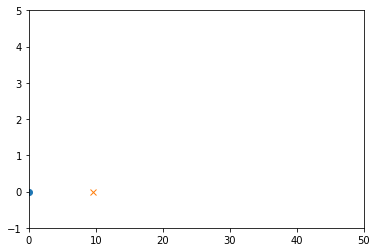

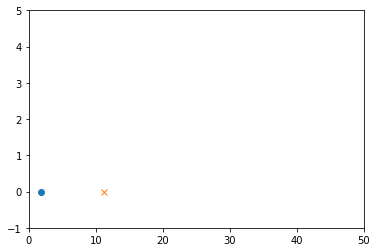

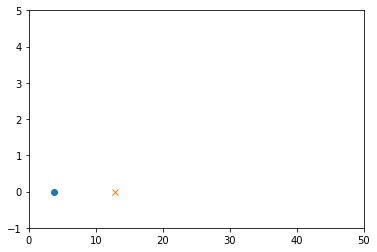

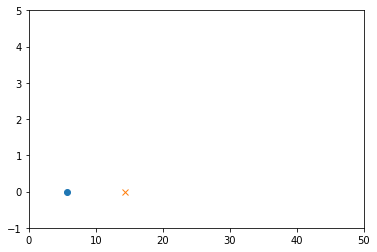

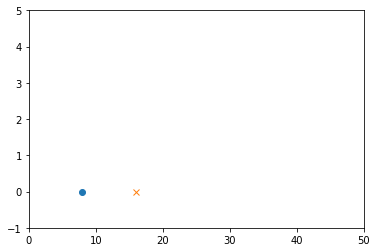

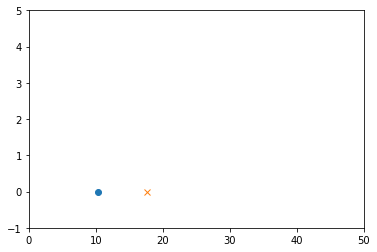

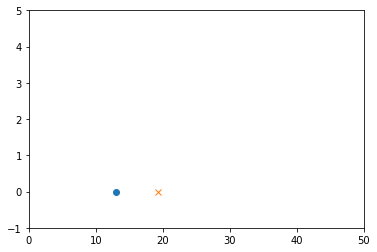

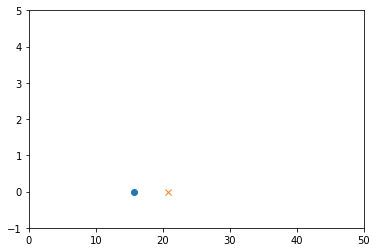

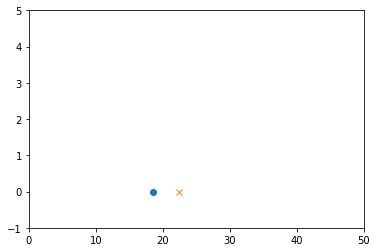

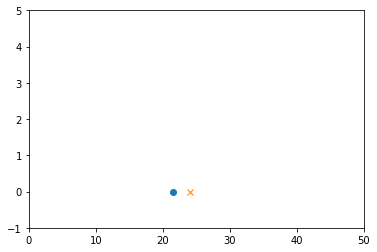

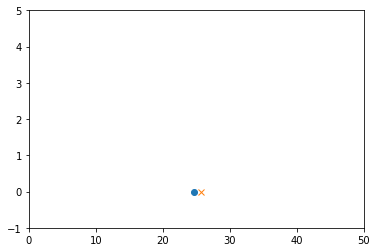

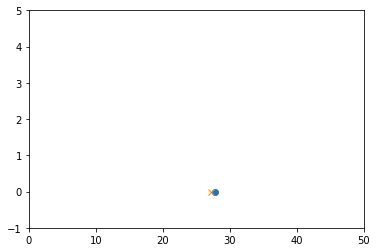

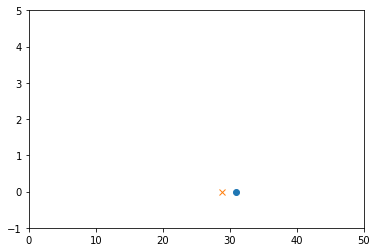

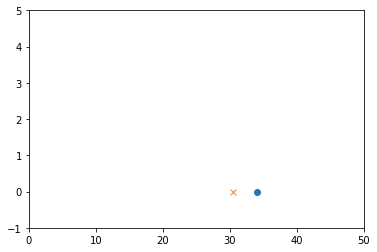

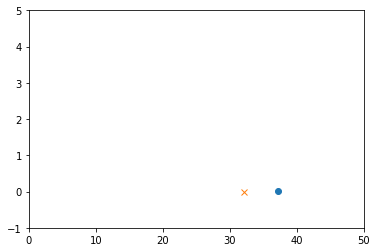

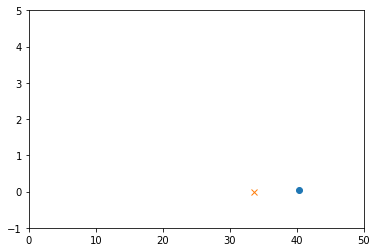

In [47]:
for k in range(len(x_deb[0,:])):
    plt.plot(x_deb[0,k], x_deb[1,k], 'o')
    plt.plot(x_others[0][0,k], x_others[0][1,k],'x')
    plt.xlim([0, 50])
    plt.ylim([-1, 5])
    plt.show()

In [30]:
bri.opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 192/1326 ------ 
0 <= 24.0207 <= 0 (viol 24.0207)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:156 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 0.
------- i = 193/1326 ------ 
0 <= -8.67362e-19 <= 0 (viol 8.67362e-19)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:156 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 1.
------- i = 194/1326 ------ 
0 <= 4.91924e-15 <= 0 (viol 4.91924e-15)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:156 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k]

In [31]:
xamb = bri.opti.debug.value(bri.x_opt)
xothers = [bri.opti.debug.value(bri.allother_x_opt[i]) for i in range(n_other)]

(0, 10)

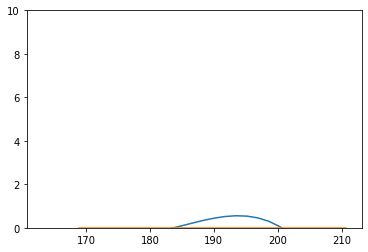

In [74]:
plt.plot(xamb[0,:], xamb[1,:])
for i in range(n_other):
    plt.plot(xothers[i][0,:], xothers[i][1,:])
plt.ylim([0, 10])

In [ ]:
x1_MPC.f(actual_xothers[0][:,0], actual_uothers[0][:,0])

In [ ]:
x1_MPC.F_kutta(x1_MPC.f, actual_xothers[0][:,0], actual_uothers[0][:,0])

In [ ]:
actual_xothers[0][:,1]

In [ ]:
plt.plot(actual_uothers[0][0,:10],'o')

In [ ]:
x0_amb[2]

In [16]:
print(bri.opti.debug.value(bri.x_opt[0,:]))
for i in range(n_other):
    print(bri.opti.debug.value(bri.allother_x_opt[i][0,:]))

[ 8.91 10.87 12.98 15.26 17.69 20.29 23.03 25.84 28.63 31.35 33.94 36.4
 38.72 40.9  42.98 44.98]
[17.97 19.65 21.32 23.   24.68 26.35 28.03 29.7  31.38 33.05 34.73 36.4
 38.08 39.75 41.43 43.1 ]
[ 5.24  6.91  8.59 10.27 11.94 13.62 15.29 16.97 18.65 20.32 22.   23.67
 25.35 27.02 28.69 30.37]


In [15]:
bri.opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 96/846 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:153 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 0.
------- i = 97/846 ------ 
0 <= -4.33681e-19 <= 0 (viol 4.33681e-19)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:153 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 1.
------- i = 98/846 ------ 
0 <= -4.33681e-19 <= 0 (viol 4.33681e-19)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/MPC_Casadi.py:153 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At no

## Plotting

In [81]:
print(N, number_ctrl_pts_executed, n_rounds_mpc, n_total_round)
print(folder)

50 5 20 2
results/20200316_131917ellipses/


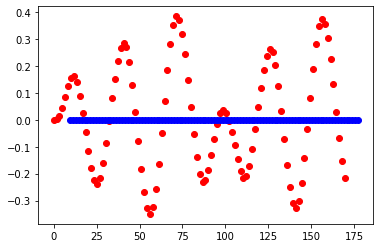

In [82]:

n_full_rounds = 0  # rounods that the ambulance planned 
n_all_rounds = 0

all_xamb = np.zeros((6, N, 1))
all_uamb = np.zeros((2, N, 1))

all_other_x = [np.zeros((6, N, 1)) for i in range(n_other)]
all_other_u = [np.zeros((2, N, 1)) for i in range(n_other)]

actual_xamb = np.zeros((6, n_rounds_mpc*number_ctrl_pts_executed + 1))
actual_xothers = [np.zeros((6, n_rounds_mpc*number_ctrl_pts_executed + 1)) for i in range(n_other)]

for i_mpc in range(n_rounds_mpc):
    file_name = folder + "data/"+'r%02d%03d'%(i_mpc, n_total_round-1)
    actual_t = i_mpc * number_ctrl_pts_executed

    xamb, uamb, xamb_des, xothers, uothers, xothers_des = mibr.load_state(file_name, n_other )  

    actual_xamb[:,actual_t:actual_t+number_ctrl_pts_executed+1]  =   xamb[:,:number_ctrl_pts_executed+1]    
    for i in range(len(actual_xothers)):
        actual_xothers[i][:,actual_t:actual_t+number_ctrl_pts_executed+1] = xothers[i][:,:number_ctrl_pts_executed+1]
#             actual_uothers[i][:,actual_t:actual_t+number_ctrl_pts_executed] = uothers[i][:,:number_ctrl_pts_executed]

    PLOT = False
    if PLOT:
        plt.plot(actual_xamb[0,actual_t:actual_t+number_ctrl_pts_executed+1],actual_xamb[1,actual_t:actual_t+number_ctrl_pts_executed+1],'o',color='red')
        plt.plot(xamb[0,:],xamb[1,:],'.',color='red')

        for i in range(n_other):
            plt.plot(actual_xothers[i][0,actual_t:actual_t+number_ctrl_pts_executed+1],actual_xothers[i][1,actual_t:actual_t+number_ctrl_pts_executed+1],'o',color='b')
            plt.plot(xothers[i][0,:],xothers[i][1,:],'.',color='blue')        

        plt.ylim(-40, 40)
        plt.xlim(0, 400)
        plt.show()
plt.plot(actual_xamb[0,:],actual_xamb[1,:],'o',color='red')
for i in range(n_other):
    plt.plot(actual_xothers[i][0,:],actual_xothers[i][1,:],'o',color='b')
plt.show()

In [83]:
cmplot.plot_cars(world, x1_MPC, actual_xamb, actual_xothers, folder, 
                                            None, None, CIRCLES=False, parallelize=True, camera_speed=np.mean(actual_xamb[4,:]))

 # folder = "results/" + subdir_name + "/"
# ibr_prefix = str(i_mpc)
# vid_fname = folder + "vids/" + 'circle_' + subdir + ibr_prefix + '.mp4'
# cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
# os.system(cmd)



In [84]:
ibr_prefix = str(1)
vid_fname = folder + "vids/" + 'ellipse_' + subdir_name + ibr_prefix + '.mp4'
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)


0

In [65]:
vid_fname

'results/20200316_131917ellipses/vids/ellipse_20200316_131917ellipses1.mp4'

In [60]:
pwd

'/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/python_experiments'

In [ ]:
###SUBSTITUTE THE XAMB_ONLY FUNCTION HERE
        if XAMB_ONLY:
            pass
        else:
            for i in range(len(all_other_MPC)):
                response_MPC = all_other_MPC[i]
                response_x0 = all_other_x0[i]

                nonresponse_MPC_list = all_other_MPC[:i] + all_other_MPC[i+1:]
                nonresponse_x0_list = all_other_x0[:i] + all_other_x0[i+1:]

                # all_other_u changes over time
                nonresponse_u_list = all_other_u[:i] + all_other_u[i+1:]

                bri = mibr.IterativeBestResponseMPCMultiple(response_MPC, amb_MPC, nonresponse_MPC_list )
                bri.k_slack = 1.0
                bri.k_CA = 100.0
                bri.generate_optimization(N, T, response_x0, x0_amb, nonresponse_x0_list,  1, slack=True)
                try:
                    bri.opti.set_initial(bri.x_opt, xothers[i])
                    bri.opti.set_initial(bri.u_opt, uothers[i])

                    bri.solve(uamb, nonresponse_u_list)
                    x1, u1, x1_des, xamb, uamb, xamb_des, other_x, other_u, other_des = bri.get_solution()
                    print("i_mpc %d n_round %d  i %02d Cost %.02f Slack %.02f "%(i_mpc, n_round, i, bri.solution.value(bri.total_svo_cost), bri.solution.value(bri.slack_cost)))
                    print("Dir:", subdir_name)

                    if bri.solution.value(bri.slack_cost) <= min_slack:
                        # Update the responder
                        all_other_u[i] = u1

                        #for saving
                        xothers = other_x[:i] + [x1] + other_x[i:]
                        uothers = other_u[:i] + [u1] + other_u[i:]
                        xothers_des = other_des[:i] + [x1_des] + other_des[i:]

                        file_name = folder + "data/"+'%03d'%ibr_sub_it
                        mibr.save_state(file_name, xamb, uamb, xamb_des, xothers, uothers, xothers_des)
                        mibr.save_costs(file_name, bri)
                    else: 
                        print("Slack too large")    
                except RuntimeError:
                    print("Max Iterations or Infeasible")
                ibr_sub_it+=1